**Salamander Triplet Network**

Created by Alejandro Marin (816035363)

Edited by:

In [1]:
!pip install -q tensorflow pandas matplotlib opencv-python

In [2]:
import os
os.listdir()

['.config', 'LynxID2025.zip', 'metadata.csv', 'sample_data']

# Reattempt From Scratch

## Inherited Code (from Siamese Attempt)

Just copied it down here


In [3]:
!unzip -q LynxID2025.zip -d .

In [4]:
import pandas as pd

# Load the original metadata but remove images
df = pd.read_csv('metadata.csv')

# Fixed the 'path' column to remove 'images/' prefix - using colab and loading each separately, image is WAY too big to load
df['path'] = df['path'].str.replace(r'^images/', '', regex=True)

# Save the fixed version for reuse in later phases
df.to_csv('metadata_fixed.csv', index=False)

print(df.head())


   image_id            identity  \
0         0  LynxID2025_lynx_37   
1         1  LynxID2025_lynx_37   
2         2  LynxID2025_lynx_49   
3         3                 NaN   
4         4  LynxID2025_lynx_13   

                                                path date orientation species  \
0  LynxID2025/database/000f9ee1aad063a4485379ec06...  NaN       right    lynx   
1  LynxID2025/database/0020edb6689e9f78462394d5a6...  NaN        left    lynx   
2  LynxID2025/database/003152e4145b5b6940091d5c12...  NaN        left    lynx   
3  LynxID2025/query/003b89301c7b9f6d18f722082617f...  NaN        back    lynx   
4  LynxID2025/database/003c3f82011e9c3f849f945a93...  NaN       right    lynx   

      split     dataset  
0  database  LynxID2025  
1  database  LynxID2025  
2  database  LynxID2025  
3     query  LynxID2025  
4  database  LynxID2025  


## Step 1 - Load Triplets

Very similar to before with siamese

In [5]:
import pandas as pd
from collections import defaultdict
import random
from itertools import product

# Load fixed metadata
df = pd.read_csv('metadata_fixed.csv')

# Step 1: Filter for LynxID2025, database split only
df = df[(df['dataset'] == 'LynxID2025') & (df['split'] == 'database')]

# Step 2: Drop rows with missing critical data
df = df.dropna(subset=['identity', 'orientation', 'path'])

# Step 3: Group images by identity and orientation
grouped_data = defaultdict(lambda: defaultdict(list))

for _, row in df.iterrows():
    identity = row['identity']
    orientation = row['orientation'].lower()
    path = row['path']
    grouped_data[identity][orientation].append(path)

# Step 4: Generate triplets (anchor, positive, negative)
triplets = []

identities = list(grouped_data.keys())

for identity in identities:
    # Flatten all images under this identity across orientations
    pos_images = [img for imgs in grouped_data[identity].values() for img in imgs]
    if len(pos_images) < 2:
        continue  # Need at least two to form anchor-positive

    # Generate anchor-positive pairs
    for anchor, positive in product(pos_images, pos_images):
        if anchor == positive:
            continue  # Don't pair image with itself

        # Select a negative identity
        negative_candidates = [id2 for id2 in identities if id2 != identity and grouped_data[id2]]
        if not negative_candidates:
            continue

        negative_id = random.choice(negative_candidates)
        negative_imgs = [img for imgs in grouped_data[negative_id].values() for img in imgs]
        if not negative_imgs:
            continue

        negative = random.choice(negative_imgs)
        triplets.append((anchor, positive, negative))

print(f"Generated {len(triplets)} triplets")
print("Example triplet:", triplets[0])


Generated 436452 triplets
Example triplet: ('LynxID2025/database/000f9ee1aad063a4485379ec06741251344f57ba0e8e6546dfc4c3b83f28c0db.jpg', 'LynxID2025/database/0e9a6eadacd86b409e9422df8707352779dfa10ef5a295167bda558aac371ac0.jpg', 'LynxID2025/database/3bf2924fdd43d08dff8e82b4ef52ce3a51c51eac6e333bb64493e80ed9e56a7a.jpg')


Manual Check Using Example Generated:

eafd41b675ff3330_1893 ID: 2

e80dc66902b38838_1881 ID: 2

a0ecd050c2ae1881_1309 ID: 139

In [6]:
# Load a triplet (anchor, positive, negative) and return ((inputs), dummy_label)
def load_triplet(anchor_path, pos_path, neg_path):
    anchor = preprocess_image(anchor_path)
    positive = preprocess_image(pos_path)
    negative = preprocess_image(neg_path)
    return (anchor, positive, negative), 0.0  # critical fix

In [7]:
import tensorflow as tf
import random

# Cap triplets
N = 250000
random.shuffle(triplets)

IMG_SIZE = (224, 224)

# Preprocessing function for a single image
def preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image

# Load a triplet (anchor, positive, negative)
def load_triplet(anchor_path, pos_path, neg_path):
    anchor = preprocess_image(anchor_path)
    positive = preprocess_image(pos_path)
    negative = preprocess_image(neg_path)
    return (anchor, positive, negative), 0.0  # Dummy label

# Convert paths to tensors
anchor_paths = tf.constant([t[0] for t in triplets])
pos_paths    = tf.constant([t[1] for t in triplets])
neg_paths    = tf.constant([t[2] for t in triplets])

# Build dataset
dataset = tf.data.Dataset.from_tensor_slices((anchor_paths, pos_paths, neg_paths))
dataset = dataset.map(load_triplet, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)


## Step 2- Define Model

In [8]:
from tensorflow.keras import layers, Model, regularizers

def create_embedding_network(input_shape=(224, 224, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128)(x)  # final embedding (no activation)

    return Model(inputs, x, name="EmbeddingNetwork")


## Step 3 - Set Up Model

In [9]:
embedding_net = create_embedding_network()

input_anchor = tf.keras.Input(shape=(224, 224, 3))
input_positive = tf.keras.Input(shape=(224, 224, 3))
input_negative = tf.keras.Input(shape=(224, 224, 3))

emb_anchor = embedding_net(input_anchor)
emb_positive = embedding_net(input_positive)
emb_negative = embedding_net(input_negative)

model = tf.keras.Model(
    inputs=[input_anchor, input_positive, input_negative],
    outputs=layers.Lambda(lambda x: tf.stack(x, axis=1))([emb_anchor, emb_positive, emb_negative])
)



In [10]:
def triplet_loss(anchor, positive, negative, margin=1.1):
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    loss = tf.maximum(pos_dist - neg_dist + margin, 0.0)
    return tf.reduce_mean(loss)


In [11]:
def full_triplet_loss(y_true, y_pred):
    anchor = y_pred[:, 0, :]
    positive = y_pred[:, 1, :]
    negative = y_pred[:, 2, :]
    return triplet_loss(anchor, positive, negative)


In [36]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss=full_triplet_loss)

model.fit(dataset, epochs=10) #equals AT LEAST 12 hrs lol


Epoch 1/10
 7072/13640 ━━━━━━━━━━━━━━━━━━━━ 30:10 276ms/step - loss: 0.0201

KeyboardInterrupt: 

Save Model

In [14]:
# Save the entire triplet model (architecture + weights + optimizer)
model.save("triplet_model_lynx.h5")


In [ ]:
model.save_weights('triplet_weights.h5')  # Just weights

# Later, recreate the model and load the weights
model = tf.keras.Model(inputs=[input_anchor, input_positive, input_negative],
                       outputs=[embedding_net(input_anchor), embedding_net(input_positive), embedding_net(input_negative)])
model.load_weights('triplet_weights.h5')


Load:

In [ ]:
from tensorflow.keras.models import load_model

# Custom loss must be passed in again
def triplet_loss(anchor, positive, negative, margin=0.5):
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    return tf.reduce_mean(tf.maximum(pos_dist - neg_dist + margin, 0.0))

def full_triplet_loss(y_true, y_pred):
    return triplet_loss(y_pred[0], y_pred[1], y_pred[2])

# Load the model and recompile with custom loss
model = load_model("triplet_model.h5", custom_objects={'full_triplet_loss': full_triplet_loss})


## Manual Test

In [ ]:
import random
import tensorflow as tf

# === Utility to embed a single image ===
def embed_image(path):
    img = preprocess_image(path)
    img = tf.expand_dims(img, axis=0)  # add batch dim
    return embedding_net(img).numpy().squeeze()

# === Step 1: Select 5 Positive Pairs ===
positive_pairs = []

for identity, orientation_dict in grouped_data.items():
    all_imgs = [img for imgs in orientation_dict.values() for img in imgs]
    if len(all_imgs) >= 2:
        img1, img2 = random.sample(all_imgs, 2)
        positive_pairs.append((img1, img2))

    if len(positive_pairs) >= 5:
        break

# === Step 2: Select 5 Negative Pairs ===
negative_pairs = []

ids = list(grouped_data.keys())
while len(negative_pairs) < 5:
    id1, id2 = random.sample(ids, 2)
    imgs1 = [img for imgs in grouped_data[id1].values() for img in imgs]
    imgs2 = [img for imgs in grouped_data[id2].values() for img in imgs]

    if imgs1 and imgs2:
        img1 = random.choice(imgs1)
        img2 = random.choice(imgs2)
        negative_pairs.append((img1, img2))

# === Step 3: Compare distances ===
print("Positive Pairs (Same ID):")
for img1, img2 in positive_pairs:
    emb1 = embed_image(img1)
    emb2 = embed_image(img2)
    dist = tf.norm(emb1 - emb2).numpy()
    print(f"  {img1} <-> {img2} → Distance: {dist:.4f}")

print("\nNegative Pairs (Different ID):")
for img1, img2 in negative_pairs:
    emb1 = embed_image(img1)
    emb2 = embed_image(img2)
    dist = tf.norm(emb1 - emb2).numpy()
    print(f"  {img1} <-> {img2} → Distance: {dist:.4f}")


Positive Pairs (Same ID):
  SeaTurtleID2022/database/turtles-data/data/images/t001/rArWeMiEhi_17.JPG <-> SeaTurtleID2022/database/turtles-data/data/images/t001/CAluWEgwPX_1.JPG → Distance: 1.1306
  SeaTurtleID2022/database/turtles-data/data/images/t002/hPCHQNBqcs_32.JPG <-> SeaTurtleID2022/database/turtles-data/data/images/t002/AWKZYHmepZ_23.JPG → Distance: 2.0820
  SeaTurtleID2022/database/turtles-data/data/images/t003/iUreCLgujg_7777.jpeg <-> SeaTurtleID2022/database/turtles-data/data/images/t003/IsRboHQOvH_42.jpg → Distance: 1.5458
  SeaTurtleID2022/database/turtles-data/data/images/t004/VEmdnrnZaq_87.jpg <-> SeaTurtleID2022/database/turtles-data/data/images/t004/WdDLexzwWs_88.jpg → Distance: 1.0518
  SeaTurtleID2022/database/turtles-data/data/images/t006/dFJLspgzYe_121.jpg <-> SeaTurtleID2022/database/turtles-data/data/images/t006/OkVkJUWvVm_119.JPG → Distance: 2.4621

Negative Pairs (Different ID):
  SeaTurtleID2022/database/turtles-data/data/images/t377/PerYcbLYzt_6777.JPG <-> Se

### Find Better Threshold

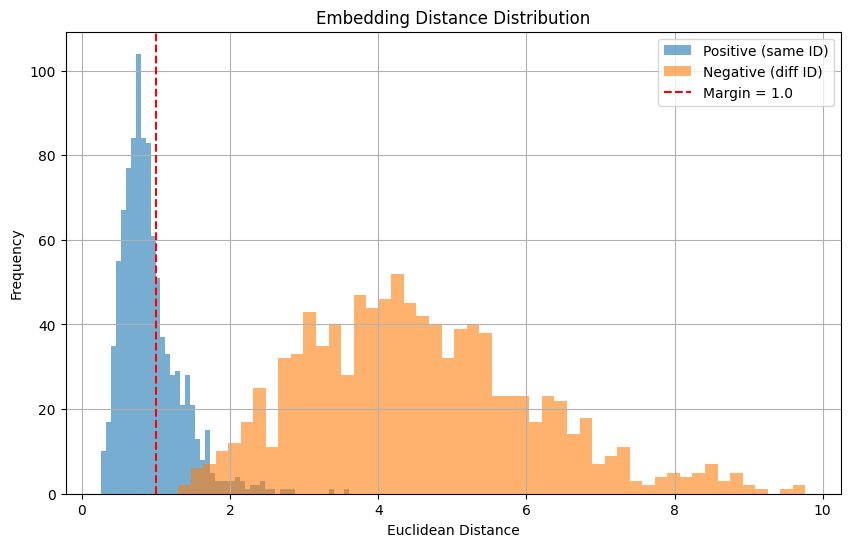

In [15]:
import matplotlib.pyplot as plt
import numpy as np

positive_distances = []
negative_distances = []

# Loop through a few triplets to compute distances
for anchor_path, pos_path, neg_path in random.sample(triplets, min(1000, len(triplets))):
    anc = preprocess_image(anchor_path)
    pos = preprocess_image(pos_path)
    neg = preprocess_image(neg_path)

    anc_emb = embedding_net(tf.expand_dims(anc, axis=0))
    pos_emb = embedding_net(tf.expand_dims(pos, axis=0))
    neg_emb = embedding_net(tf.expand_dims(neg, axis=0))

    # Euclidean distances
    pos_dist = tf.norm(anc_emb - pos_emb).numpy()
    neg_dist = tf.norm(anc_emb - neg_emb).numpy()

    positive_distances.append(pos_dist)
    negative_distances.append(neg_dist)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(positive_distances, bins=50, alpha=0.6, label='Positive (same ID)')
plt.hist(negative_distances, bins=50, alpha=0.6, label='Negative (diff ID)')
plt.axvline(x=1.0, color='red', linestyle='--', label='Margin = 1.0')
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")
plt.title("Embedding Distance Distribution")
plt.legend()
plt.grid(True)
plt.show()




For reference, this was the one for the siamese:



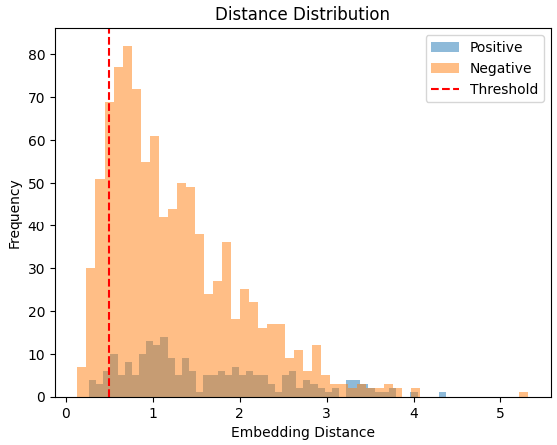

Absolute Optimal

In [16]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# --- 1. Load metadata ---
df = pd.read_csv('metadata_fixed.csv')
df = df[(df['dataset'] == 'LynxID2025') & (df['split'] == 'database')]
df = df.dropna(subset=['identity', 'path'])

# --- 2. Create validation positive and negative pairs ---
from collections import defaultdict
import random

grouped = defaultdict(list)
for _, row in df.iterrows():
    grouped[row['identity']].append(row['path'])

positive_pairs = []
negative_pairs = []

identities = list(grouped.keys())

for identity in identities:
    imgs = grouped[identity]
    if len(imgs) >= 2:
        for i in range(min(2, len(imgs)-1)):
            positive_pairs.append((imgs[i], imgs[i+1], 1))

# Sample negatives
for _ in range(len(positive_pairs)):
    id1, id2 = random.sample(identities, 2)
    img1 = random.choice(grouped[id1])
    img2 = random.choice(grouped[id2])
    negative_pairs.append((img1, img2, 0))

all_pairs = positive_pairs + negative_pairs
random.shuffle(all_pairs)

# --- 3. Preprocessing ---
IMG_SIZE = (224, 224)

def preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    return image / 255.0

def preprocess_pair(img1_path, img2_path, label):
    img1 = preprocess_image(img1_path)
    img2 = preprocess_image(img2_path)
    return (img1, img2), tf.cast(label, tf.float32)

# --- 4. Build val_dataset ---
img1_paths = [p[0] for p in all_pairs]
img2_paths = [p[1] for p in all_pairs]
labels     = [p[2] for p in all_pairs]

val_dataset = tf.data.Dataset.from_tensor_slices((img1_paths, img2_paths, labels))
val_dataset = val_dataset.map(preprocess_pair, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [17]:
positive_distances = []
negative_distances = []

for (img1_batch, img2_batch), label_batch in val_dataset:
    for img1, img2, label in zip(img1_batch, img2_batch, label_batch):
        emb1 = embedding_net(tf.expand_dims(img1, 0))
        emb2 = embedding_net(tf.expand_dims(img2, 0))
        dist = tf.norm(emb1 - emb2).numpy()

        if label.numpy() == 1:
            positive_distances.append(dist)
        else:
            negative_distances.append(dist)


In [18]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score


all_distances = np.array(positive_distances + negative_distances)
all_labels = np.array([1]*len(positive_distances) + [0]*len(negative_distances))

best_f1 = 0
best_threshold = 0

for threshold in np.linspace(0.1, 5.0, 200):
    preds = (all_distances < threshold).astype(int)  # Closer = same individual
    f1 = f1_score(all_labels, preds, zero_division=0)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Final evaluation
final_preds = (all_distances < best_threshold).astype(int)
precision = precision_score(all_labels, final_preds, zero_division=0)
recall = recall_score(all_labels, final_preds, zero_division=0)

print(f"Best threshold: {best_threshold:.4f}")
print(f"F1 Score: {best_f1:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")


Best threshold: 3.3256
F1 Score: 0.9137
Precision: 0.9071, Recall: 0.9203


In [19]:
import numpy as np
from sklearn.metrics import f1_score

all_distances = np.array(positive_distances + negative_distances)
all_labels = np.array([1]*len(positive_distances) + [0]*len(negative_distances))

best_f1 = 0
best_threshold = 0

for threshold in np.linspace(0.1, 5.0, 200):  # Try many values
    preds = (all_distances < threshold).astype(int)  # 1 if close = match
    f1 = f1_score(all_labels, preds)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best threshold: {best_threshold:.4f} with F1: {best_f1:.4f}")


Best threshold: 3.3256 with F1: 0.9137


Visualise

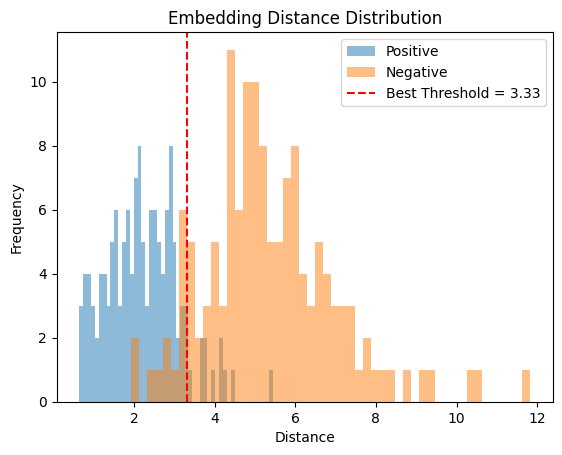

In [20]:
import matplotlib.pyplot as plt

plt.hist(positive_distances, bins=50, alpha=0.5, label='Positive')
plt.hist(negative_distances, bins=50, alpha=0.5, label='Negative')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.legend()
plt.title('Embedding Distance Distribution')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()


**F1 Scores**

In [21]:
import numpy as np

all_distances = np.array(positive_distances + negative_distances)
all_labels = np.array([1]*len(positive_distances) + [0]*len(negative_distances))


In [22]:
from sklearn.metrics import f1_score, precision_score, recall_score

thresholds = np.linspace(0.1, 5.0, 200)
f1_scores = []
precisions = []
recalls = []

for t in thresholds:
    preds = (all_distances < t).astype(int)
    f1_scores.append(f1_score(all_labels, preds))
    precisions.append(precision_score(all_labels, preds))
    recalls.append(recall_score(all_labels, preds))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

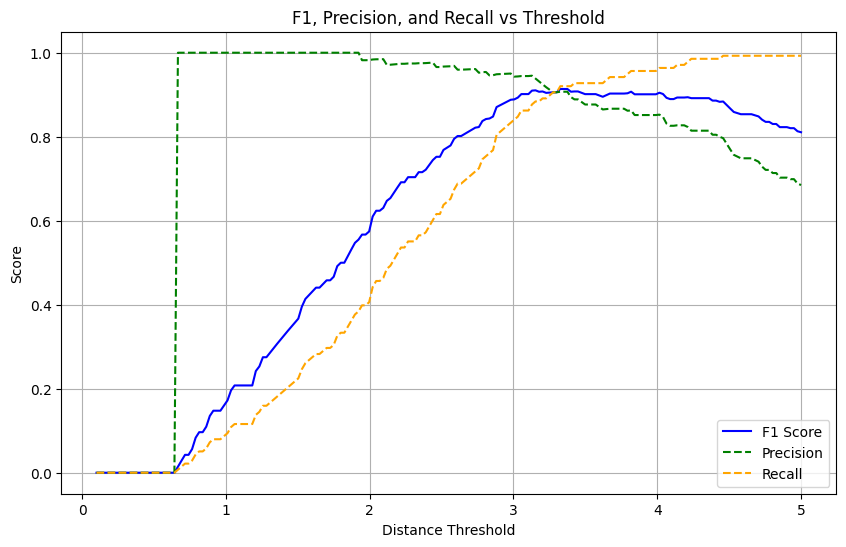

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', color='blue')
plt.plot(thresholds, precisions, label='Precision', color='green', linestyle='--')
plt.plot(thresholds, recalls, label='Recall', color='orange', linestyle='--')
plt.xlabel('Distance Threshold')
plt.ylabel('Score')
plt.title('F1, Precision, and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.4f}, F1 Score: {best_f1:.4f}")


Best Threshold: 2.2668, F1 Score: 0.8311


## Step 4.1 - Predict Using Optimal Theshold

In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm

# Load fixed metadata
df = pd.read_csv("metadata_fixed.csv")

# Filter for LynxID2025
db_df = df[(df['dataset'] == 'LynxID2025') & (df['split'] == 'database')].dropna(subset=['identity', 'path'])
query_df = df[(df['dataset'] == 'LynxID2025') & (df['split'] == 'query')].dropna(subset=['path'])

print(f"DB images: {len(db_df)}, Query images: {len(query_df)}")


DB images: 2957, Query images: 946


In [25]:
IMG_SIZE = (224, 224)

def preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    return image / 255.0

# Build DB embeddings
db_paths = db_df['path'].tolist()
db_ids = db_df['identity'].tolist()

db_embeddings = []
valid_db_ids = []

for path, identity in tqdm(zip(db_paths, db_ids), total=len(db_paths)):
    try:
        img = preprocess_image(path)
        emb = embedding_net(tf.expand_dims(img, 0)).numpy().squeeze()
        db_embeddings.append(emb)
        valid_db_ids.append(identity)
    except Exception as e:
        print(f"Skipping {path}: {e}")

db_embeddings = np.array(db_embeddings)
print(f"Total valid DB embeddings: {len(db_embeddings)}")


100%|██████████| 2957/2957 [00:59<00:00, 49.90it/s]

Total valid DB embeddings: 2957


In [28]:
threshold = 1.8  # Based on the histogram

results = []

for _, row in tqdm(query_df.iterrows(), total=len(query_df)):
    path = row['path']
    try:
        img = preprocess_image(path)
        query_emb = embedding_net(tf.expand_dims(img, 0)).numpy().squeeze()

        # Calculate Euclidean distances to all DB embeddings
        dists = np.linalg.norm(db_embeddings - query_emb, axis=1)
        min_idx = np.argmin(dists)
        min_dist = dists[min_idx]

        predicted_id = "new_individual" if min_dist > threshold else valid_db_ids[min_idx]

        results.append({
            'query_path': path,
            'predicted_id': predicted_id,
            'distance': min_dist
        })
    except Exception as e:
        print(f"Error with {path}: {e}")


100%|██████████| 946/946 [00:23<00:00, 40.63it/s]


# The Next Stage

## Add Augmented Phase

Avoid


In [ ]:
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image

def preprocess_image(path, augment=False):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0
    if augment:
        image = augment_image(image)
    return image


In [ ]:
def load_triplet(anchor_path, pos_path, neg_path):
    anchor = preprocess_image(anchor_path, augment=False)   # Anchor stays clean
    positive = preprocess_image(pos_path, augment=True)     # Apply augmentation
    negative = preprocess_image(neg_path, augment=True)
    return (anchor, positive, negative), 0.0


In [ ]:

anchor_paths = tf.constant([t[0] for t in triplets])
pos_paths    = tf.constant([t[1] for t in triplets])
neg_paths    = tf.constant([t[2] for t in triplets])

# Rebuild dataset with augmentation logic
augmented_dataset = tf.data.Dataset.from_tensor_slices((anchor_paths, pos_paths, neg_paths))
augmented_dataset = augmented_dataset.map(load_triplet, num_parallel_calls=tf.data.AUTOTUNE)
augmented_dataset = augmented_dataset.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
model.fit(augmented_dataset, epochs=10)

Epoch 1/10
  636/11070 ━━━━━━━━━━━━━━━━━━━━ 48:43 280ms/step - loss: 0.6470

KeyboardInterrupt: 

# The Next Next Stage

## Add NN

In [32]:
import pandas as pd
import numpy as np
from collections import defaultdict
import tensorflow as tf
from itertools import combinations
import random

# Load metadata
df = pd.read_csv("/content/metadata_fixed.csv")

# Filter LynxID2025 and database
df = df[(df['dataset'] == 'LynxID2025') & (df['split'] == 'database')]
df = df.dropna(subset=['identity', 'orientation', 'path'])

# Group by identity
identity_to_paths = defaultdict(list)
for _, row in df.iterrows():
    identity_to_paths[row['identity']].append(row['path'])

# === Parameters ===
MAX_POS_PER_ID = 50   # Max positive pairs per identity
MAX_TOTAL_NEG = 3000   # Total negative pairs to generate

# Generate positive pairs
positive_pairs = []
for identity, paths in identity_to_paths.items():
    if len(paths) < 2:
        continue
    all_pos = list(combinations(paths, 2))
    selected = random.sample(all_pos, min(len(all_pos), MAX_POS_PER_ID))
    positive_pairs.extend((a, b, 1) for a, b in selected)

# Generate negative pairs
negative_pairs = []
identities = list(identity_to_paths.keys())

while len(negative_pairs) < MAX_TOTAL_NEG:
    id1, id2 = random.sample(identities, 2)
    if not identity_to_paths[id1] or not identity_to_paths[id2]:
        continue
    img1 = random.choice(identity_to_paths[id1])
    img2 = random.choice(identity_to_paths[id2])
    negative_pairs.append((img1, img2, 0))

print("Positive pairs:", len(positive_pairs))
print("Negative pairs:", len(negative_pairs))

# Load embedding network (assumes already defined)
IMG_SIZE = (224, 224)

def preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    return image / 255.0

def compute_embedding(path):
    img = preprocess_image(path)
    img = tf.expand_dims(img, axis=0)
    return embedding_net(img).numpy().squeeze()

# Build dataset of embedding pairs + labels
embedding_pairs = []
labels = []

for img1_path, img2_path, label in positive_pairs + negative_pairs:
    try:
        emb1 = compute_embedding(img1_path)
        emb2 = compute_embedding(img2_path)
        combined = np.concatenate([emb1, emb2])
        embedding_pairs.append(combined)
        labels.append(label)
    except Exception as e:
        print("Failed to process:", img1_path, img2_path)

embedding_pairs = np.array(embedding_pairs)
labels = np.array(labels)
print("Final dataset shape:", embedding_pairs.shape)


Positive pairs: 2621
Negative pairs: 3000
Final dataset shape: (5621, 256)


In [33]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    embedding_pairs, labels, test_size=0.2, random_state=42, stratify=labels
)

# Build simple classifier
clf_model = models.Sequential([
    layers.Input(shape=(256,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

clf_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
clf_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32
)


Epoch 1/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.6361 - loss: 0.6218 - val_accuracy: 0.8951 - val_loss: 0.2820
Epoch 2/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8907 - loss: 0.2864 - val_accuracy: 0.9316 - val_loss: 0.1989
Epoch 3/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9209 - loss: 0.2094 - val_accuracy: 0.9404 - val_loss: 0.1762
Epoch 4/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9352 - loss: 0.1703 - val_accuracy: 0.9449 - val_loss: 0.1639
Epoch 5/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9378 - loss: 0.1604 - val_accuracy: 0.9511 - val_loss: 0.1446
Epoch 6/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9507 - loss: 0.1407 - val_accuracy: 0.9396 - val_loss: 0.1667
Epoch 7/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9536 - loss: 0.1327 - val_accuracy: 0.9476 - val_loss: 0.1508
Epoch 8/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9593 - loss: 0.1199 - val_accuracy: 0

Test Probability

In [ ]:
# Pick 1 positive pair (same identity)
img1_path_pos = "LynxID2025/database/turtles-data/data/images/t006/s4RZlp19Ej_81.JPG"
img2_path_pos = "LynxID2025/database/turtles-data/data/images/t006/3nYtb8OBVo_82.JPG"

# Pick 1 negative pair (different identity)
img1_path_neg = "LynxID2025/database/turtles-data/data/images/t006/s4RZlp19Ej_81.JPG"  # identity 6
img2_path_neg = "LynxID2025/database/turtles-data/data/images/t008/UOGqRBEmJh_103.JPG"  # identity 8

# Preprocess and embed both
def get_embedding(path):
    img = preprocess_image(path)  # from earlier
    img = tf.expand_dims(img, 0)
    return embedding_net(img).numpy()

# Positive embedding pair
emb1_pos = compute_embedding(img1_path_pos)
emb2_pos = compute_embedding(img2_path_pos)
pair_pos = np.concatenate([emb1_pos, emb2_pos], axis=1)  # shape (1, 256)

# Negative embedding pair
emb1_neg = compute_embedding(img1_path_neg)
emb2_neg = compute_embedding(img2_path_neg)
pair_neg = np.concatenate([emb1_neg, emb2_neg], axis=1)  # shape (1, 256)

# Predict probabilities
prob_pos = clf_model.predict(pair_pos)[0][0]
prob_neg = clf_model.predict(pair_neg)[0][0]

print(f"Positive Pair Probability: {prob_pos:.4f}")
print(f"Negative Pair Probability: {prob_neg:.4f}")


NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} SeaTurtleID2022/database/turtles-data/data/images/t006/s4RZlp19Ej_81.JPG; No such file or directory [Op:ReadFile]

In [34]:
import pandas as pd
import tensorflow as tf
import numpy as np
from collections import defaultdict
from tqdm import tqdm

# Load metadata
df = pd.read_csv('metadata_fixed.csv')

# Filter for LynxID2025 database images
db_df = df[(df['dataset'] == 'LynxID2025') & (df['split'] == 'database')].dropna(subset=['identity', 'path'])

db_image_paths = db_df['path'].tolist()
db_identities = db_df['identity'].tolist()

# Precompute embeddings
db_embeddings = []
valid_db_paths = []
valid_db_ids = []

for path, identity in tqdm(zip(db_image_paths, db_identities), total=len(db_image_paths)):
    try:
        img = preprocess_image(path)
        img = tf.expand_dims(img, 0)
        emb = embedding_net(img).numpy()
        db_embeddings.append(emb)
        valid_db_paths.append(path)
        valid_db_ids.append(identity)
    except:
        continue

print(f"Loaded {len(db_embeddings)} DB embeddings")


100%|██████████| 2957/2957 [01:00<00:00, 49.13it/s]

Loaded 2957 DB embeddings


In [35]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf

# --- Load metadata ---
df = pd.read_csv('metadata_fixed.csv')

# --- Get DB (with identity) ---
db_df = df[(df['dataset'] == 'LynxID2025') & (df['split'] == 'database')].dropna(subset=['identity', 'path'])
db_paths = db_df['path'].tolist()
db_ids = db_df['identity'].tolist()

# Precompute DB embeddings
db_embeddings = []
valid_db_ids = []

for path, identity in tqdm(zip(db_paths, db_ids), desc="DB Embeddings", total=len(db_paths)):
    try:
        img = preprocess_image(path)
        img = tf.expand_dims(img, 0)
        emb = embedding_net(img).numpy().squeeze()
        db_embeddings.append(emb)
        valid_db_ids.append(identity)
    except:
        pass

# --- Get Query images ---
query_df = df[(df['dataset'] == 'LynxID2025') & (df['split'] == 'query')].dropna(subset=['path'])
query_paths = query_df['path'].tolist()

# --- Predict via NN using batching ---
threshold = 0.5  # Set based on validation or histogram analysis
final_predictions = []

for path in tqdm(query_paths, desc="Predicting"):
    try:
        img = preprocess_image(path)
        img = tf.expand_dims(img, 0)
        q_emb = embedding_net(img).numpy().squeeze()

        # Repeat query emb for each db emb (batch input)
        q_batch = np.repeat(np.expand_dims(q_emb, axis=0), len(db_embeddings), axis=0)
        db_batch = np.array(db_embeddings)

        # Concatenate to form (q_emb | db_emb) pairs
        pair_input = np.concatenate([q_batch, db_batch], axis=1)

        # Predict in batch
        probs = clf_model.predict(pair_input, batch_size=128).squeeze()

        max_idx = np.argmax(probs)
        max_prob = probs[max_idx]

        pred_id = "new_individual" if max_prob < threshold else valid_db_ids[max_idx]
        final_predictions.append((path, pred_id))

    except Exception as e:
        print(f"Error processing {path}: {e}")
        final_predictions.append((path, "error"))

# --- Format results using proper metadata mapping ---
meta_full = pd.read_csv("metadata_fixed.csv")
submission_df = pd.DataFrame(final_predictions, columns=['path', 'identity'])
merged_df = pd.merge(submission_df, meta_full[['path', 'image_id']], how='left', on='path')

final_df = merged_df[['image_id', 'identity']].dropna().astype({'image_id': int})
final_df = final_df.sort_values('image_id')

# Save for submission
final_df.to_csv('salamander_submission.csv', index=False)
print("Salamander submission saved")


Predicting:   0%|          | 0/946 [00:00<?, ?it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


Predicting:   0%|          | 1/946 [00:00<11:19,  1.39it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   0%|          | 2/946 [00:00<05:48,  2.71it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   0%|          | 3/946 [00:00<04:01,  3.90it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   0%|          | 4/946 [00:01<03:13,  4.86it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   1%|          | 5/946 [00:01<02:50,  5.52it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   1%|          | 6/946 [00:01<02:32,  6.15it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   1%|          | 7/946 [00:01<02:24,  6.50it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   1%|          | 8/946 [00:01<02:15,  6.95it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   1%|          | 9/946 [00:01<02:18,  6.77it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   1%|          | 10/946 [00:01<02:10,  7.16it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   1%|          | 11/946 [00:02<02:11,  7.09it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   1%|▏         | 12/946 [00:02<02:05,  7.46it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   1%|▏         | 13/946 [00:02<02:01,  7.70it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   1%|▏         | 14/946 [00:02<01:59,  7.81it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   2%|▏         | 15/946 [00:02<02:02,  7.58it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   2%|▏         | 16/946 [00:02<02:01,  7.67it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   2%|▏         | 17/946 [00:02<02:05,  7.43it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   2%|▏         | 18/946 [00:03<02:39,  5.82it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   2%|▏         | 19/946 [00:03<02:28,  6.24it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   2%|▏         | 20/946 [00:03<02:21,  6.55it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   2%|▏         | 21/946 [00:03<02:17,  6.73it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   2%|▏         | 22/946 [00:03<02:11,  7.01it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   2%|▏         | 23/946 [00:03<02:15,  6.80it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   3%|▎         | 24/946 [00:03<02:16,  6.75it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   3%|▎         | 25/946 [00:04<02:09,  7.10it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   3%|▎         | 26/946 [00:04<02:10,  7.04it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   3%|▎         | 27/946 [00:04<02:05,  7.31it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   3%|▎         | 28/946 [00:04<02:06,  7.25it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   3%|▎         | 29/946 [00:04<02:15,  6.79it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   3%|▎         | 30/946 [00:04<02:08,  7.12it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   3%|▎         | 31/946 [00:04<02:04,  7.34it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   3%|▎         | 32/946 [00:05<02:10,  7.02it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   3%|▎         | 33/946 [00:05<02:10,  7.00it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   4%|▎         | 34/946 [00:05<02:10,  7.01it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   4%|▎         | 35/946 [00:05<02:04,  7.33it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   4%|▍         | 36/946 [00:05<02:00,  7.58it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   4%|▍         | 37/946 [00:05<02:07,  7.13it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   4%|▍         | 38/946 [00:05<02:07,  7.12it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   4%|▍         | 39/946 [00:05<02:07,  7.14it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   4%|▍         | 40/946 [00:06<02:03,  7.31it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   4%|▍         | 41/946 [00:06<02:02,  7.37it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   4%|▍         | 42/946 [00:06<02:09,  6.99it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   5%|▍         | 43/946 [00:06<02:08,  7.04it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   5%|▍         | 44/946 [00:06<02:04,  7.24it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   5%|▍         | 45/946 [00:06<01:59,  7.57it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   5%|▍         | 46/946 [00:06<01:59,  7.50it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   5%|▍         | 47/946 [00:07<01:57,  7.68it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   5%|▌         | 48/946 [00:07<02:18,  6.47it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   5%|▌         | 49/946 [00:07<02:09,  6.91it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   5%|▌         | 50/946 [00:07<02:04,  7.17it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   5%|▌         | 51/946 [00:07<02:01,  7.38it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   5%|▌         | 52/946 [00:07<02:03,  7.26it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   6%|▌         | 53/946 [00:07<02:06,  7.03it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   6%|▌         | 54/946 [00:08<02:09,  6.88it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   6%|▌         | 55/946 [00:08<02:32,  5.85it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   6%|▌         | 56/946 [00:08<02:19,  6.37it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   6%|▌         | 57/946 [00:08<02:14,  6.59it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   6%|▌         | 58/946 [00:08<02:05,  7.07it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   6%|▌         | 59/946 [00:08<02:00,  7.37it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   6%|▋         | 60/946 [00:08<01:56,  7.60it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   6%|▋         | 61/946 [00:09<01:56,  7.61it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   7%|▋         | 62/946 [00:09<01:55,  7.63it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   7%|▋         | 63/946 [00:09<02:09,  6.83it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   7%|▋         | 64/946 [00:09<02:03,  7.15it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   7%|▋         | 65/946 [00:09<01:58,  7.45it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   7%|▋         | 66/946 [00:09<01:53,  7.76it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   7%|▋         | 67/946 [00:09<01:55,  7.59it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   7%|▋         | 68/946 [00:10<01:54,  7.70it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   7%|▋         | 69/946 [00:10<01:52,  7.82it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   7%|▋         | 70/946 [00:10<01:53,  7.75it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   8%|▊         | 71/946 [00:10<01:54,  7.67it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   8%|▊         | 72/946 [00:10<02:05,  6.97it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   8%|▊         | 73/946 [00:10<02:00,  7.22it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   8%|▊         | 74/946 [00:10<01:59,  7.33it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   8%|▊         | 75/946 [00:10<01:57,  7.38it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   8%|▊         | 76/946 [00:11<02:06,  6.85it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   8%|▊         | 77/946 [00:11<02:01,  7.15it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   8%|▊         | 78/946 [00:11<02:08,  6.74it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   8%|▊         | 79/946 [00:11<02:02,  7.06it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   8%|▊         | 80/946 [00:11<01:56,  7.44it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   9%|▊         | 81/946 [00:11<01:53,  7.61it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   9%|▊         | 82/946 [00:11<01:50,  7.83it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   9%|▉         | 83/946 [00:12<01:52,  7.69it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   9%|▉         | 84/946 [00:12<02:02,  7.05it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   9%|▉         | 85/946 [00:12<01:56,  7.39it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   9%|▉         | 86/946 [00:12<01:53,  7.55it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   9%|▉         | 87/946 [00:12<01:51,  7.73it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   9%|▉         | 88/946 [00:12<01:51,  7.70it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:   9%|▉         | 89/946 [00:12<01:50,  7.75it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  10%|▉         | 90/946 [00:12<01:49,  7.82it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  10%|▉         | 91/946 [00:13<01:50,  7.72it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  10%|▉         | 92/946 [00:13<01:48,  7.89it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  10%|▉         | 93/946 [00:13<01:59,  7.11it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  10%|▉         | 94/946 [00:13<01:54,  7.41it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  10%|█         | 95/946 [00:13<01:51,  7.62it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  10%|█         | 96/946 [00:13<01:50,  7.71it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  10%|█         | 97/946 [00:13<01:48,  7.80it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  10%|█         | 98/946 [00:14<01:56,  7.26it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  10%|█         | 99/946 [00:14<02:04,  6.81it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  11%|█         | 100/946 [00:14<02:04,  6.78it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  11%|█         | 101/946 [00:14<01:57,  7.18it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  11%|█         | 102/946 [00:14<01:54,  7.38it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  11%|█         | 103/946 [00:14<01:51,  7.57it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  11%|█         | 104/946 [00:14<01:50,  7.63it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  11%|█         | 105/946 [00:15<01:57,  7.15it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  11%|█         | 106/946 [00:15<02:04,  6.77it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  11%|█▏        | 107/946 [00:15<02:05,  6.68it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  11%|█▏        | 108/946 [00:15<02:10,  6.40it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  12%|█▏        | 109/946 [00:15<02:02,  6.82it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  12%|█▏        | 110/946 [00:15<02:05,  6.67it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  12%|█▏        | 111/946 [00:15<02:06,  6.60it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  12%|█▏        | 112/946 [00:16<02:01,  6.86it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  12%|█▏        | 113/946 [00:16<02:00,  6.94it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  12%|█▏        | 114/946 [00:16<01:57,  7.11it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  12%|█▏        | 115/946 [00:16<01:58,  7.02it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  12%|█▏        | 116/946 [00:16<01:56,  7.10it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  12%|█▏        | 117/946 [00:16<01:51,  7.43it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  12%|█▏        | 118/946 [00:16<01:52,  7.36it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  13%|█▎        | 119/946 [00:17<01:51,  7.43it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  13%|█▎        | 120/946 [00:17<01:48,  7.65it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  13%|█▎        | 121/946 [00:17<01:45,  7.80it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  13%|█▎        | 122/946 [00:17<01:45,  7.84it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  13%|█▎        | 123/946 [00:17<01:45,  7.82it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  13%|█▎        | 124/946 [00:17<01:43,  7.91it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  13%|█▎        | 125/946 [00:17<01:54,  7.17it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  13%|█▎        | 126/946 [00:17<01:53,  7.25it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  13%|█▎        | 127/946 [00:18<01:50,  7.44it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  14%|█▎        | 128/946 [00:18<01:51,  7.35it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  14%|█▎        | 129/946 [00:18<01:46,  7.64it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  14%|█▎        | 130/946 [00:18<01:44,  7.84it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  14%|█▍        | 131/946 [00:18<01:43,  7.88it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  14%|█▍        | 132/946 [00:18<01:41,  8.02it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  14%|█▍        | 133/946 [00:18<01:40,  8.09it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  14%|█▍        | 134/946 [00:18<01:41,  8.00it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  14%|█▍        | 135/946 [00:19<01:47,  7.57it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  14%|█▍        | 136/946 [00:19<01:48,  7.47it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  14%|█▍        | 137/946 [00:19<01:56,  6.96it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  15%|█▍        | 138/946 [00:19<01:58,  6.80it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  15%|█▍        | 139/946 [00:19<01:54,  7.02it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  15%|█▍        | 140/946 [00:19<01:50,  7.31it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  15%|█▍        | 141/946 [00:19<01:53,  7.12it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  15%|█▌        | 142/946 [00:20<01:48,  7.40it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  15%|█▌        | 143/946 [00:20<01:46,  7.56it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  15%|█▌        | 144/946 [00:20<01:52,  7.14it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  15%|█▌        | 145/946 [00:20<01:52,  7.15it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  15%|█▌        | 146/946 [00:20<01:49,  7.32it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  16%|█▌        | 147/946 [00:20<01:46,  7.47it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  16%|█▌        | 148/946 [00:20<01:48,  7.34it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  16%|█▌        | 149/946 [00:21<01:47,  7.43it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  16%|█▌        | 150/946 [00:21<01:49,  7.26it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  16%|█▌        | 151/946 [00:21<01:50,  7.20it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  16%|█▌        | 152/946 [00:21<01:49,  7.25it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  16%|█▌        | 153/946 [00:21<01:47,  7.36it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  16%|█▋        | 154/946 [00:21<01:45,  7.53it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  16%|█▋        | 155/946 [00:21<01:44,  7.54it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  16%|█▋        | 156/946 [00:22<01:45,  7.46it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  17%|█▋        | 157/946 [00:22<01:47,  7.32it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  17%|█▋        | 158/946 [00:22<01:45,  7.47it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  17%|█▋        | 159/946 [00:22<01:43,  7.62it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  17%|█▋        | 160/946 [00:22<01:43,  7.61it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  17%|█▋        | 161/946 [00:22<01:41,  7.76it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  17%|█▋        | 162/946 [00:22<01:39,  7.88it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  17%|█▋        | 163/946 [00:22<01:38,  7.92it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  17%|█▋        | 164/946 [00:23<01:38,  7.91it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  17%|█▋        | 165/946 [00:23<01:37,  7.98it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  18%|█▊        | 166/946 [00:23<01:38,  7.95it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  18%|█▊        | 167/946 [00:23<01:55,  6.72it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  18%|█▊        | 168/946 [00:23<01:53,  6.87it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  18%|█▊        | 169/946 [00:23<01:48,  7.18it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  18%|█▊        | 170/946 [00:23<01:54,  6.78it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  18%|█▊        | 171/946 [00:24<01:48,  7.13it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  18%|█▊        | 172/946 [00:24<01:45,  7.36it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  18%|█▊        | 173/946 [00:24<01:45,  7.35it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  18%|█▊        | 174/946 [00:24<01:41,  7.59it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  18%|█▊        | 175/946 [00:24<01:43,  7.48it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  19%|█▊        | 176/946 [00:24<01:39,  7.71it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  19%|█▊        | 177/946 [00:24<01:36,  7.96it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  19%|█▉        | 178/946 [00:24<01:40,  7.63it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  19%|█▉        | 179/946 [00:25<01:42,  7.52it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  19%|█▉        | 180/946 [00:25<01:41,  7.58it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  19%|█▉        | 181/946 [00:25<01:40,  7.59it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  19%|█▉        | 182/946 [00:25<01:42,  7.49it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  19%|█▉        | 183/946 [00:25<01:42,  7.42it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  19%|█▉        | 184/946 [00:25<01:45,  7.22it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  20%|█▉        | 185/946 [00:25<01:51,  6.81it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  20%|█▉        | 186/946 [00:26<01:49,  6.94it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  20%|█▉        | 187/946 [00:26<01:49,  6.96it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  20%|█▉        | 188/946 [00:26<01:45,  7.22it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  20%|█▉        | 189/946 [00:26<01:46,  7.12it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  20%|██        | 190/946 [00:26<01:45,  7.14it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  20%|██        | 191/946 [00:26<01:42,  7.36it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  20%|██        | 192/946 [00:26<01:40,  7.49it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  20%|██        | 193/946 [00:27<01:38,  7.65it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  21%|██        | 194/946 [00:27<01:39,  7.58it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  21%|██        | 195/946 [00:27<01:36,  7.76it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  21%|██        | 196/946 [00:27<01:45,  7.08it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  21%|██        | 197/946 [00:27<01:47,  6.98it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  21%|██        | 198/946 [00:27<01:48,  6.91it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  21%|██        | 199/946 [00:27<01:49,  6.85it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  21%|██        | 200/946 [00:27<01:44,  7.16it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  21%|██        | 201/946 [00:28<01:48,  6.86it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  21%|██▏       | 202/946 [00:28<01:42,  7.27it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  21%|██▏       | 203/946 [00:28<01:42,  7.25it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  22%|██▏       | 204/946 [00:28<01:41,  7.32it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  22%|██▏       | 205/946 [00:28<01:37,  7.57it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  22%|██▏       | 206/946 [00:28<01:35,  7.71it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  22%|██▏       | 207/946 [00:28<01:34,  7.79it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  22%|██▏       | 208/946 [00:29<01:32,  7.94it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  22%|██▏       | 209/946 [00:29<01:32,  7.98it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  22%|██▏       | 210/946 [00:29<01:34,  7.81it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  22%|██▏       | 211/946 [00:29<01:42,  7.18it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  22%|██▏       | 212/946 [00:29<01:38,  7.48it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  23%|██▎       | 213/946 [00:29<01:35,  7.69it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  23%|██▎       | 214/946 [00:29<01:33,  7.80it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  23%|██▎       | 215/946 [00:29<01:33,  7.81it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  23%|██▎       | 216/946 [00:30<01:32,  7.89it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  23%|██▎       | 217/946 [00:30<01:31,  8.01it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  23%|██▎       | 218/946 [00:30<01:32,  7.87it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  23%|██▎       | 219/946 [00:30<01:37,  7.49it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  23%|██▎       | 220/946 [00:30<01:35,  7.60it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  23%|██▎       | 221/946 [00:30<01:33,  7.76it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  23%|██▎       | 222/946 [00:30<01:34,  7.68it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  24%|██▎       | 223/946 [00:30<01:31,  7.88it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  24%|██▎       | 224/946 [00:31<01:31,  7.93it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  24%|██▍       | 225/946 [00:31<01:30,  7.98it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  24%|██▍       | 226/946 [00:31<01:38,  7.27it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  24%|██▍       | 227/946 [00:31<01:37,  7.34it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  24%|██▍       | 228/946 [00:31<01:39,  7.19it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  24%|██▍       | 229/946 [00:31<01:34,  7.56it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  24%|██▍       | 230/946 [00:31<01:34,  7.59it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  24%|██▍       | 231/946 [00:32<01:36,  7.42it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  25%|██▍       | 232/946 [00:32<01:33,  7.62it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  25%|██▍       | 233/946 [00:32<01:33,  7.65it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  25%|██▍       | 234/946 [00:32<01:34,  7.53it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  25%|██▍       | 235/946 [00:32<01:33,  7.65it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  25%|██▍       | 236/946 [00:32<01:35,  7.42it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  25%|██▌       | 237/946 [00:32<01:43,  6.85it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  25%|██▌       | 238/946 [00:33<01:42,  6.92it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  25%|██▌       | 239/946 [00:33<01:44,  6.74it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  25%|██▌       | 240/946 [00:33<01:42,  6.88it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  25%|██▌       | 241/946 [00:33<01:39,  7.07it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  26%|██▌       | 242/946 [00:33<01:36,  7.28it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  26%|██▌       | 243/946 [00:33<01:43,  6.77it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  26%|██▌       | 244/946 [00:33<01:49,  6.40it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  26%|██▌       | 245/946 [00:34<01:52,  6.22it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  26%|██▌       | 246/946 [00:34<01:44,  6.69it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  26%|██▌       | 247/946 [00:34<01:38,  7.09it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  26%|██▌       | 248/946 [00:34<01:35,  7.27it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  26%|██▋       | 249/946 [00:34<01:39,  7.00it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  26%|██▋       | 250/946 [00:34<01:41,  6.87it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  27%|██▋       | 251/946 [00:34<01:37,  7.14it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  27%|██▋       | 252/946 [00:35<01:34,  7.38it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  27%|██▋       | 253/946 [00:35<01:33,  7.43it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  27%|██▋       | 254/946 [00:35<01:44,  6.61it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  27%|██▋       | 255/946 [00:35<01:40,  6.88it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  27%|██▋       | 256/946 [00:35<01:49,  6.31it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  27%|██▋       | 257/946 [00:35<01:43,  6.63it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  27%|██▋       | 258/946 [00:35<01:38,  7.01it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  27%|██▋       | 259/946 [00:36<01:44,  6.60it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  27%|██▋       | 260/946 [00:36<01:46,  6.46it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  28%|██▊       | 261/946 [00:36<01:42,  6.66it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  28%|██▊       | 262/946 [00:36<01:39,  6.91it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  28%|██▊       | 263/946 [00:36<01:35,  7.18it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  28%|██▊       | 264/946 [00:36<01:39,  6.85it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  28%|██▊       | 265/946 [00:36<01:36,  7.09it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  28%|██▊       | 266/946 [00:37<01:36,  7.03it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  28%|██▊       | 267/946 [00:37<01:41,  6.71it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  28%|██▊       | 268/946 [00:37<01:37,  6.93it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  28%|██▊       | 269/946 [00:37<01:40,  6.73it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  29%|██▊       | 270/946 [00:37<01:44,  6.48it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  29%|██▊       | 271/946 [00:37<01:39,  6.75it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  29%|██▉       | 272/946 [00:38<01:38,  6.84it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  29%|██▉       | 273/946 [00:38<01:35,  7.05it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  29%|██▉       | 274/946 [00:38<01:34,  7.08it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  29%|██▉       | 275/946 [00:38<01:34,  7.10it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  29%|██▉       | 276/946 [00:38<01:31,  7.29it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  29%|██▉       | 277/946 [00:38<01:32,  7.27it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  29%|██▉       | 278/946 [00:38<01:35,  6.98it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  29%|██▉       | 279/946 [00:38<01:33,  7.16it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  30%|██▉       | 280/946 [00:39<01:37,  6.82it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  30%|██▉       | 281/946 [00:39<01:44,  6.35it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  30%|██▉       | 282/946 [00:39<01:41,  6.54it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  30%|██▉       | 283/946 [00:39<01:35,  6.91it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  30%|███       | 284/946 [00:39<01:32,  7.12it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  30%|███       | 285/946 [00:39<01:29,  7.40it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  30%|███       | 286/946 [00:40<01:35,  6.89it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  30%|███       | 287/946 [00:40<01:33,  7.03it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  30%|███       | 288/946 [00:40<01:31,  7.20it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  31%|███       | 289/946 [00:40<01:35,  6.86it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  31%|███       | 290/946 [00:40<01:34,  6.94it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  31%|███       | 291/946 [00:40<01:34,  6.96it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  31%|███       | 292/946 [00:40<01:33,  7.02it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  31%|███       | 293/946 [00:41<01:44,  6.26it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  31%|███       | 294/946 [00:41<01:37,  6.70it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  31%|███       | 295/946 [00:41<01:34,  6.89it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  31%|███▏      | 296/946 [00:41<01:30,  7.16it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  31%|███▏      | 297/946 [00:41<01:29,  7.28it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  32%|███▏      | 298/946 [00:41<01:26,  7.53it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  32%|███▏      | 299/946 [00:41<01:24,  7.63it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  32%|███▏      | 300/946 [00:41<01:27,  7.39it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  32%|███▏      | 301/946 [00:42<01:24,  7.59it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  32%|███▏      | 302/946 [00:42<01:24,  7.58it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  32%|███▏      | 303/946 [00:42<01:24,  7.60it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  32%|███▏      | 304/946 [00:42<01:26,  7.43it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  32%|███▏      | 305/946 [00:42<01:24,  7.60it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  32%|███▏      | 306/946 [00:42<01:30,  7.10it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  32%|███▏      | 307/946 [00:42<01:33,  6.84it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  33%|███▎      | 308/946 [00:43<01:29,  7.12it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  33%|███▎      | 309/946 [00:43<01:28,  7.24it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  33%|███▎      | 310/946 [00:43<01:29,  7.09it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  33%|███▎      | 311/946 [00:43<01:26,  7.38it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  33%|███▎      | 312/946 [00:43<01:32,  6.88it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  33%|███▎      | 313/946 [00:43<01:28,  7.15it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  33%|███▎      | 314/946 [00:43<01:26,  7.34it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  33%|███▎      | 315/946 [00:44<01:36,  6.53it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  33%|███▎      | 316/946 [00:44<01:40,  6.25it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  34%|███▎      | 317/946 [00:44<01:59,  5.25it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  34%|███▎      | 318/946 [00:44<01:47,  5.82it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  34%|███▎      | 319/946 [00:44<01:42,  6.10it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  34%|███▍      | 320/946 [00:44<01:37,  6.45it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  34%|███▍      | 321/946 [00:45<01:32,  6.78it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  34%|███▍      | 322/946 [00:45<01:31,  6.80it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  34%|███▍      | 323/946 [00:45<01:30,  6.90it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  34%|███▍      | 324/946 [00:45<01:26,  7.15it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  34%|███▍      | 325/946 [00:45<01:25,  7.24it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  34%|███▍      | 326/946 [00:45<01:31,  6.79it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  35%|███▍      | 327/946 [00:45<01:37,  6.37it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  35%|███▍      | 328/946 [00:46<01:33,  6.62it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  35%|███▍      | 329/946 [00:46<01:30,  6.85it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  35%|███▍      | 330/946 [00:46<01:26,  7.12it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  35%|███▍      | 331/946 [00:46<01:30,  6.77it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  35%|███▌      | 332/946 [00:46<01:26,  7.12it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  35%|███▌      | 333/946 [00:46<01:23,  7.32it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  35%|███▌      | 334/946 [00:46<01:20,  7.57it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  35%|███▌      | 335/946 [00:47<01:23,  7.29it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  36%|███▌      | 336/946 [00:47<01:24,  7.19it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  36%|███▌      | 337/946 [00:47<01:21,  7.45it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  36%|███▌      | 338/946 [00:47<01:20,  7.53it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  36%|███▌      | 339/946 [00:47<01:20,  7.53it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  36%|███▌      | 340/946 [00:47<01:21,  7.47it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  36%|███▌      | 341/946 [00:47<01:19,  7.62it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  36%|███▌      | 342/946 [00:47<01:17,  7.80it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  36%|███▋      | 343/946 [00:48<01:26,  6.98it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  36%|███▋      | 344/946 [00:48<01:26,  6.93it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  36%|███▋      | 345/946 [00:48<01:33,  6.39it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  37%|███▋      | 346/946 [00:48<01:31,  6.56it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  37%|███▋      | 347/946 [00:48<01:31,  6.58it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  37%|███▋      | 348/946 [00:48<01:27,  6.80it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  37%|███▋      | 349/946 [00:49<01:25,  6.97it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  37%|███▋      | 350/946 [00:49<01:26,  6.93it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  37%|███▋      | 351/946 [00:49<01:25,  6.99it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  37%|███▋      | 352/946 [00:49<01:24,  7.04it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  37%|███▋      | 353/946 [00:49<01:23,  7.14it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  37%|███▋      | 354/946 [00:49<01:20,  7.34it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  38%|███▊      | 355/946 [00:49<01:19,  7.43it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  38%|███▊      | 356/946 [00:50<01:26,  6.84it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  38%|███▊      | 357/946 [00:50<01:23,  7.05it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  38%|███▊      | 358/946 [00:50<01:21,  7.19it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  38%|███▊      | 359/946 [00:50<01:19,  7.37it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  38%|███▊      | 360/946 [00:50<01:29,  6.56it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  38%|███▊      | 361/946 [00:50<01:35,  6.15it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  38%|███▊      | 362/946 [00:50<01:29,  6.50it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  38%|███▊      | 363/946 [00:51<01:28,  6.57it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  38%|███▊      | 364/946 [00:51<01:24,  6.92it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  39%|███▊      | 365/946 [00:51<01:26,  6.71it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  39%|███▊      | 366/946 [00:51<01:22,  7.05it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  39%|███▉      | 367/946 [00:51<01:20,  7.24it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  39%|███▉      | 368/946 [00:51<01:23,  6.92it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  39%|███▉      | 369/946 [00:51<01:19,  7.22it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  39%|███▉      | 370/946 [00:52<01:20,  7.11it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  39%|███▉      | 371/946 [00:52<01:18,  7.30it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  39%|███▉      | 372/946 [00:52<01:17,  7.44it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  39%|███▉      | 373/946 [00:52<01:18,  7.34it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  40%|███▉      | 374/946 [00:52<01:24,  6.75it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  40%|███▉      | 375/946 [00:52<01:22,  6.91it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  40%|███▉      | 376/946 [00:52<01:19,  7.20it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  40%|███▉      | 377/946 [00:53<01:18,  7.29it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  40%|███▉      | 378/946 [00:53<01:17,  7.34it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  40%|████      | 379/946 [00:53<01:23,  6.80it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  40%|████      | 380/946 [00:53<01:20,  7.00it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  40%|████      | 381/946 [00:53<01:23,  6.80it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  40%|████      | 382/946 [00:53<01:21,  6.93it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  40%|████      | 383/946 [00:53<01:18,  7.13it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  41%|████      | 384/946 [00:54<01:26,  6.47it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  41%|████      | 385/946 [00:54<01:22,  6.79it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  41%|████      | 386/946 [00:54<01:20,  6.99it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  41%|████      | 387/946 [00:54<01:17,  7.21it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  41%|████      | 388/946 [00:54<01:16,  7.31it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  41%|████      | 389/946 [00:54<01:19,  7.04it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  41%|████      | 390/946 [00:54<01:16,  7.23it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  41%|████▏     | 391/946 [00:55<01:14,  7.42it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  41%|████▏     | 392/946 [00:55<01:15,  7.37it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  42%|████▏     | 393/946 [00:55<01:16,  7.23it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  42%|████▏     | 394/946 [00:55<01:18,  7.03it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  42%|████▏     | 395/946 [00:55<01:17,  7.10it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  42%|████▏     | 396/946 [00:55<01:20,  6.86it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  42%|████▏     | 397/946 [00:55<01:16,  7.19it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  42%|████▏     | 398/946 [00:56<01:20,  6.78it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  42%|████▏     | 399/946 [00:56<01:17,  7.04it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  42%|████▏     | 400/946 [00:56<01:16,  7.17it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  42%|████▏     | 401/946 [00:56<01:14,  7.29it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  42%|████▏     | 402/946 [00:56<01:13,  7.40it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  43%|████▎     | 403/946 [00:56<01:12,  7.51it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  43%|████▎     | 404/946 [00:56<01:19,  6.85it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  43%|████▎     | 405/946 [00:56<01:16,  7.06it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  43%|████▎     | 406/946 [00:57<01:13,  7.38it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  43%|████▎     | 407/946 [00:57<01:18,  6.88it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  43%|████▎     | 408/946 [00:57<01:17,  6.92it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  43%|████▎     | 409/946 [00:57<01:15,  7.10it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  43%|████▎     | 410/946 [00:57<01:17,  6.92it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  43%|████▎     | 411/946 [00:57<01:14,  7.18it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  44%|████▎     | 412/946 [00:57<01:12,  7.40it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  44%|████▎     | 413/946 [00:58<01:19,  6.74it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  44%|████▍     | 414/946 [00:58<01:26,  6.15it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  44%|████▍     | 415/946 [00:58<01:22,  6.48it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  44%|████▍     | 416/946 [00:58<01:17,  6.83it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  44%|████▍     | 417/946 [00:58<01:16,  6.91it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  44%|████▍     | 418/946 [00:58<01:14,  7.08it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  44%|████▍     | 419/946 [00:59<01:13,  7.22it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  44%|████▍     | 420/946 [00:59<01:15,  6.99it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  45%|████▍     | 421/946 [00:59<01:14,  7.02it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  45%|████▍     | 422/946 [00:59<01:13,  7.14it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  45%|████▍     | 423/946 [00:59<01:11,  7.34it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  45%|████▍     | 424/946 [00:59<01:14,  7.01it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  45%|████▍     | 425/946 [00:59<01:12,  7.15it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  45%|████▌     | 426/946 [01:00<01:15,  6.88it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  45%|████▌     | 427/946 [01:00<01:30,  5.72it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  45%|████▌     | 428/946 [01:00<01:27,  5.95it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  45%|████▌     | 429/946 [01:00<01:29,  5.77it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  45%|████▌     | 430/946 [01:00<01:22,  6.23it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  46%|████▌     | 431/946 [01:00<01:18,  6.54it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  46%|████▌     | 432/946 [01:01<01:16,  6.72it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  46%|████▌     | 433/946 [01:01<01:12,  7.08it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  46%|████▌     | 434/946 [01:01<01:20,  6.36it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  46%|████▌     | 435/946 [01:01<01:16,  6.69it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  46%|████▌     | 436/946 [01:01<01:17,  6.60it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  46%|████▌     | 437/946 [01:01<01:21,  6.22it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  46%|████▋     | 438/946 [01:01<01:17,  6.56it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  46%|████▋     | 439/946 [01:02<01:13,  6.86it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  47%|████▋     | 440/946 [01:02<01:10,  7.18it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  47%|████▋     | 441/946 [01:02<01:10,  7.20it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  47%|████▋     | 442/946 [01:02<01:07,  7.45it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  47%|████▋     | 443/946 [01:02<01:12,  6.89it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  47%|████▋     | 444/946 [01:02<01:09,  7.22it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  47%|████▋     | 445/946 [01:02<01:07,  7.46it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  47%|████▋     | 446/946 [01:02<01:07,  7.43it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  47%|████▋     | 447/946 [01:03<01:10,  7.08it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  47%|████▋     | 448/946 [01:03<01:08,  7.26it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  47%|████▋     | 449/946 [01:03<01:06,  7.44it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  48%|████▊     | 450/946 [01:03<01:09,  7.12it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  48%|████▊     | 451/946 [01:03<01:08,  7.22it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  48%|████▊     | 452/946 [01:03<01:06,  7.44it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  48%|████▊     | 453/946 [01:03<01:06,  7.43it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  48%|████▊     | 454/946 [01:04<01:05,  7.50it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  48%|████▊     | 455/946 [01:04<01:05,  7.54it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  48%|████▊     | 456/946 [01:04<01:07,  7.26it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  48%|████▊     | 457/946 [01:04<01:05,  7.50it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  48%|████▊     | 458/946 [01:04<01:06,  7.32it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  49%|████▊     | 459/946 [01:04<01:07,  7.18it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  49%|████▊     | 460/946 [01:04<01:07,  7.24it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  49%|████▊     | 461/946 [01:05<01:06,  7.34it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  49%|████▉     | 462/946 [01:05<01:05,  7.41it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  49%|████▉     | 463/946 [01:05<01:07,  7.17it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  49%|████▉     | 464/946 [01:05<01:11,  6.70it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  49%|████▉     | 465/946 [01:05<01:11,  6.77it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  49%|████▉     | 466/946 [01:05<01:09,  6.95it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  49%|████▉     | 467/946 [01:05<01:06,  7.25it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  49%|████▉     | 468/946 [01:06<01:04,  7.36it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  50%|████▉     | 469/946 [01:06<01:04,  7.45it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  50%|████▉     | 470/946 [01:06<01:06,  7.18it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  50%|████▉     | 471/946 [01:06<01:04,  7.31it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  50%|████▉     | 472/946 [01:06<01:02,  7.55it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  50%|█████     | 473/946 [01:06<01:02,  7.56it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  50%|█████     | 474/946 [01:06<01:01,  7.70it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  50%|█████     | 475/946 [01:06<01:00,  7.79it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  50%|█████     | 476/946 [01:07<01:00,  7.72it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  50%|█████     | 477/946 [01:07<01:03,  7.40it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  51%|█████     | 478/946 [01:07<01:01,  7.64it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  51%|█████     | 479/946 [01:07<01:05,  7.18it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  51%|█████     | 480/946 [01:07<01:10,  6.65it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  51%|█████     | 481/946 [01:07<01:10,  6.60it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  51%|█████     | 482/946 [01:07<01:08,  6.79it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  51%|█████     | 483/946 [01:08<01:05,  7.03it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  51%|█████     | 484/946 [01:08<01:04,  7.20it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  51%|█████▏    | 485/946 [01:08<01:01,  7.44it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  51%|█████▏    | 486/946 [01:08<01:02,  7.31it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  51%|█████▏    | 487/946 [01:08<01:02,  7.32it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  52%|█████▏    | 488/946 [01:08<01:03,  7.23it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  52%|█████▏    | 489/946 [01:08<01:01,  7.49it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  52%|█████▏    | 490/946 [01:09<00:59,  7.60it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  52%|█████▏    | 491/946 [01:09<01:00,  7.47it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  52%|█████▏    | 492/946 [01:09<01:06,  6.82it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  52%|█████▏    | 493/946 [01:09<01:07,  6.75it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  52%|█████▏    | 494/946 [01:09<01:11,  6.29it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  52%|█████▏    | 495/946 [01:09<01:08,  6.57it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  52%|█████▏    | 496/946 [01:09<01:05,  6.84it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  53%|█████▎    | 497/946 [01:10<01:03,  7.12it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  53%|█████▎    | 498/946 [01:10<01:01,  7.30it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  53%|█████▎    | 499/946 [01:10<00:59,  7.51it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  53%|█████▎    | 500/946 [01:10<01:02,  7.17it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  53%|█████▎    | 501/946 [01:10<01:00,  7.32it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  53%|█████▎    | 502/946 [01:10<01:06,  6.72it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  53%|█████▎    | 503/946 [01:10<01:03,  7.03it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  53%|█████▎    | 504/946 [01:11<01:01,  7.21it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  53%|█████▎    | 505/946 [01:11<00:59,  7.39it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  53%|█████▎    | 506/946 [01:11<01:01,  7.12it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  54%|█████▎    | 507/946 [01:11<01:02,  7.03it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  54%|█████▎    | 508/946 [01:11<01:00,  7.21it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  54%|█████▍    | 509/946 [01:11<01:02,  7.03it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  54%|█████▍    | 510/946 [01:11<01:00,  7.22it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  54%|█████▍    | 511/946 [01:12<01:00,  7.24it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  54%|█████▍    | 512/946 [01:12<01:00,  7.23it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  54%|█████▍    | 513/946 [01:12<00:59,  7.29it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  54%|█████▍    | 514/946 [01:12<01:00,  7.15it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  54%|█████▍    | 515/946 [01:12<00:59,  7.26it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  55%|█████▍    | 516/946 [01:12<00:57,  7.48it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  55%|█████▍    | 517/946 [01:12<00:56,  7.53it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  55%|█████▍    | 518/946 [01:12<00:57,  7.41it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  55%|█████▍    | 519/946 [01:13<00:57,  7.39it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  55%|█████▍    | 520/946 [01:13<00:57,  7.47it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  55%|█████▌    | 521/946 [01:13<01:00,  7.02it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  55%|█████▌    | 522/946 [01:13<00:59,  7.10it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  55%|█████▌    | 523/946 [01:13<01:03,  6.71it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  55%|█████▌    | 524/946 [01:13<01:04,  6.50it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  55%|█████▌    | 525/946 [01:14<01:01,  6.80it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  56%|█████▌    | 526/946 [01:14<00:58,  7.19it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  56%|█████▌    | 527/946 [01:14<00:56,  7.36it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  56%|█████▌    | 528/946 [01:14<00:58,  7.10it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  56%|█████▌    | 529/946 [01:14<00:59,  7.06it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  56%|█████▌    | 530/946 [01:14<00:58,  7.14it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  56%|█████▌    | 531/946 [01:14<00:58,  7.15it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  56%|█████▌    | 532/946 [01:14<00:56,  7.33it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  56%|█████▋    | 533/946 [01:15<01:13,  5.62it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  56%|█████▋    | 534/946 [01:15<01:12,  5.70it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  57%|█████▋    | 535/946 [01:15<01:07,  6.05it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  57%|█████▋    | 536/946 [01:15<01:03,  6.42it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  57%|█████▋    | 537/946 [01:15<00:59,  6.85it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  57%|█████▋    | 538/946 [01:15<00:58,  6.99it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  57%|█████▋    | 539/946 [01:16<00:55,  7.28it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  57%|█████▋    | 540/946 [01:16<00:54,  7.51it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  57%|█████▋    | 541/946 [01:16<01:01,  6.63it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  57%|█████▋    | 542/946 [01:16<01:03,  6.38it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  57%|█████▋    | 543/946 [01:16<00:59,  6.75it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  58%|█████▊    | 544/946 [01:16<00:57,  7.02it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  58%|█████▊    | 545/946 [01:16<00:55,  7.19it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  58%|█████▊    | 546/946 [01:17<00:54,  7.33it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  58%|█████▊    | 547/946 [01:17<00:53,  7.46it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  58%|█████▊    | 548/946 [01:17<00:54,  7.33it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  58%|█████▊    | 549/946 [01:17<00:54,  7.30it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  58%|█████▊    | 550/946 [01:17<00:53,  7.38it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  58%|█████▊    | 551/946 [01:17<00:57,  6.89it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  58%|█████▊    | 552/946 [01:17<00:54,  7.22it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  58%|█████▊    | 553/946 [01:18<00:58,  6.68it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  59%|█████▊    | 554/946 [01:18<00:58,  6.67it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  59%|█████▊    | 555/946 [01:18<00:58,  6.65it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  59%|█████▉    | 556/946 [01:18<00:57,  6.83it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  59%|█████▉    | 557/946 [01:18<00:54,  7.09it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  59%|█████▉    | 558/946 [01:18<00:55,  7.04it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  59%|█████▉    | 559/946 [01:18<00:56,  6.86it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  59%|█████▉    | 560/946 [01:19<00:54,  7.08it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  59%|█████▉    | 561/946 [01:19<00:52,  7.36it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  59%|█████▉    | 562/946 [01:19<00:50,  7.54it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  60%|█████▉    | 563/946 [01:19<01:13,  5.24it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  60%|█████▉    | 564/946 [01:19<01:05,  5.83it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  60%|█████▉    | 565/946 [01:19<01:00,  6.34it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  60%|█████▉    | 566/946 [01:20<00:56,  6.71it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  60%|█████▉    | 567/946 [01:20<00:54,  6.91it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  60%|██████    | 568/946 [01:20<00:54,  6.89it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  60%|██████    | 569/946 [01:20<00:53,  7.11it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  60%|██████    | 570/946 [01:20<00:51,  7.24it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  60%|██████    | 571/946 [01:20<00:52,  7.21it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  60%|██████    | 572/946 [01:20<00:53,  7.00it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  61%|██████    | 573/946 [01:20<00:51,  7.26it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  61%|██████    | 574/946 [01:21<00:49,  7.44it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  61%|██████    | 575/946 [01:21<00:50,  7.34it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  61%|██████    | 576/946 [01:21<00:51,  7.22it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  61%|██████    | 577/946 [01:21<00:50,  7.29it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  61%|██████    | 578/946 [01:21<00:49,  7.40it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  61%|██████    | 579/946 [01:21<00:49,  7.39it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  61%|██████▏   | 580/946 [01:21<00:48,  7.48it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  61%|██████▏   | 581/946 [01:22<01:07,  5.42it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  62%|██████▏   | 582/946 [01:22<01:05,  5.59it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  62%|██████▏   | 583/946 [01:22<01:05,  5.52it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  62%|██████▏   | 584/946 [01:22<01:00,  6.00it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  62%|██████▏   | 585/946 [01:22<00:59,  6.10it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  62%|██████▏   | 586/946 [01:22<00:54,  6.57it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  62%|██████▏   | 587/946 [01:23<00:53,  6.76it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  62%|██████▏   | 588/946 [01:23<00:54,  6.55it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  62%|██████▏   | 589/946 [01:23<00:53,  6.73it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  62%|██████▏   | 590/946 [01:23<00:53,  6.68it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  62%|██████▏   | 591/946 [01:23<00:58,  6.03it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  63%|██████▎   | 592/946 [01:23<00:57,  6.18it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  63%|██████▎   | 593/946 [01:24<00:54,  6.54it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  63%|██████▎   | 594/946 [01:24<00:51,  6.86it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  63%|██████▎   | 595/946 [01:24<00:49,  7.07it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  63%|██████▎   | 596/946 [01:24<00:53,  6.56it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  63%|██████▎   | 597/946 [01:24<00:52,  6.68it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  63%|██████▎   | 598/946 [01:24<00:51,  6.81it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  63%|██████▎   | 599/946 [01:24<00:49,  6.98it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  63%|██████▎   | 600/946 [01:25<00:48,  7.12it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  64%|██████▎   | 601/946 [01:25<00:46,  7.37it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  64%|██████▎   | 602/946 [01:25<00:48,  7.05it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  64%|██████▎   | 603/946 [01:25<00:47,  7.16it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  64%|██████▍   | 604/946 [01:25<00:47,  7.23it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  64%|██████▍   | 605/946 [01:25<00:47,  7.20it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  64%|██████▍   | 606/946 [01:25<00:48,  6.96it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  64%|██████▍   | 607/946 [01:26<00:47,  7.19it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  64%|██████▍   | 608/946 [01:26<00:45,  7.42it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  64%|██████▍   | 609/946 [01:26<00:44,  7.51it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  64%|██████▍   | 610/946 [01:26<00:51,  6.54it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  65%|██████▍   | 611/946 [01:26<00:52,  6.39it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  65%|██████▍   | 612/946 [01:26<01:04,  5.17it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  65%|██████▍   | 613/946 [01:27<00:57,  5.74it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  65%|██████▍   | 614/946 [01:27<00:57,  5.78it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  65%|██████▌   | 615/946 [01:27<00:54,  6.07it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  65%|██████▌   | 616/946 [01:27<00:56,  5.83it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  65%|██████▌   | 617/946 [01:27<00:51,  6.33it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  65%|██████▌   | 618/946 [01:27<00:48,  6.75it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  65%|██████▌   | 619/946 [01:27<00:46,  7.02it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  66%|██████▌   | 620/946 [01:28<00:47,  6.80it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  66%|██████▌   | 621/946 [01:28<00:46,  6.98it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  66%|██████▌   | 622/946 [01:28<00:45,  7.19it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  66%|██████▌   | 623/946 [01:28<00:43,  7.36it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  66%|██████▌   | 624/946 [01:28<00:45,  7.08it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  66%|██████▌   | 625/946 [01:28<00:43,  7.34it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  66%|██████▌   | 626/946 [01:28<00:44,  7.12it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  66%|██████▋   | 627/946 [01:29<00:45,  7.02it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  66%|██████▋   | 628/946 [01:29<00:45,  7.07it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  66%|██████▋   | 629/946 [01:29<00:54,  5.83it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  67%|██████▋   | 630/946 [01:29<01:07,  4.71it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  67%|██████▋   | 631/946 [01:29<00:58,  5.36it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  67%|██████▋   | 632/946 [01:30<00:53,  5.92it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  67%|██████▋   | 633/946 [01:30<00:50,  6.14it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  67%|██████▋   | 634/946 [01:30<00:52,  6.00it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  67%|██████▋   | 635/946 [01:30<00:47,  6.50it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  67%|██████▋   | 636/946 [01:30<00:46,  6.72it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  67%|██████▋   | 637/946 [01:30<00:43,  7.07it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  67%|██████▋   | 638/946 [01:30<00:43,  7.07it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  68%|██████▊   | 639/946 [01:31<00:43,  7.11it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  68%|██████▊   | 640/946 [01:31<00:44,  6.91it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  68%|██████▊   | 641/946 [01:31<00:42,  7.14it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  68%|██████▊   | 642/946 [01:31<00:47,  6.40it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  68%|██████▊   | 643/946 [01:31<00:46,  6.50it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  68%|██████▊   | 644/946 [01:31<00:44,  6.71it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  68%|██████▊   | 645/946 [01:31<00:46,  6.41it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  68%|██████▊   | 646/946 [01:32<00:44,  6.70it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  68%|██████▊   | 647/946 [01:32<00:43,  6.81it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  68%|██████▊   | 648/946 [01:32<00:45,  6.58it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  69%|██████▊   | 649/946 [01:32<00:43,  6.89it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  69%|██████▊   | 650/946 [01:32<00:42,  6.96it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  69%|██████▉   | 651/946 [01:32<00:41,  7.19it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  69%|██████▉   | 652/946 [01:33<00:48,  6.05it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  69%|██████▉   | 653/946 [01:33<00:46,  6.24it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  69%|██████▉   | 654/946 [01:33<00:44,  6.60it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  69%|██████▉   | 655/946 [01:33<00:42,  6.78it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  69%|██████▉   | 656/946 [01:33<00:40,  7.08it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  69%|██████▉   | 657/946 [01:33<00:42,  6.83it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  70%|██████▉   | 658/946 [01:33<00:40,  7.16it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  70%|██████▉   | 659/946 [01:33<00:40,  7.09it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  70%|██████▉   | 660/946 [01:34<00:39,  7.19it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  70%|██████▉   | 661/946 [01:34<00:42,  6.63it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  70%|██████▉   | 662/946 [01:34<00:42,  6.71it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  70%|███████   | 663/946 [01:34<00:41,  6.85it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  70%|███████   | 664/946 [01:34<00:39,  7.07it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  70%|███████   | 665/946 [01:34<00:39,  7.13it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  70%|███████   | 666/946 [01:35<00:41,  6.73it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  71%|███████   | 667/946 [01:35<00:44,  6.32it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  71%|███████   | 668/946 [01:35<00:41,  6.63it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  71%|███████   | 669/946 [01:35<00:40,  6.78it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  71%|███████   | 670/946 [01:35<00:39,  7.02it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  71%|███████   | 671/946 [01:35<00:38,  7.15it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  71%|███████   | 672/946 [01:35<00:40,  6.70it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  71%|███████   | 673/946 [01:36<00:39,  6.98it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  71%|███████   | 674/946 [01:36<00:37,  7.20it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  71%|███████▏  | 675/946 [01:36<00:37,  7.31it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  71%|███████▏  | 676/946 [01:36<00:37,  7.15it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  72%|███████▏  | 677/946 [01:36<00:36,  7.31it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  72%|███████▏  | 678/946 [01:36<00:37,  7.22it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  72%|███████▏  | 679/946 [01:36<00:37,  7.19it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  72%|███████▏  | 680/946 [01:36<00:37,  7.15it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  72%|███████▏  | 681/946 [01:37<00:38,  6.96it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  72%|███████▏  | 682/946 [01:37<00:36,  7.28it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  72%|███████▏  | 683/946 [01:37<00:35,  7.39it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  72%|███████▏  | 684/946 [01:37<00:34,  7.51it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  72%|███████▏  | 685/946 [01:37<00:34,  7.61it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  73%|███████▎  | 686/946 [01:37<00:35,  7.40it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  73%|███████▎  | 687/946 [01:37<00:34,  7.42it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  73%|███████▎  | 688/946 [01:38<00:34,  7.41it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  73%|███████▎  | 689/946 [01:38<00:35,  7.24it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  73%|███████▎  | 690/946 [01:38<00:35,  7.14it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  73%|███████▎  | 691/946 [01:38<00:35,  7.17it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  73%|███████▎  | 692/946 [01:38<00:34,  7.33it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  73%|███████▎  | 693/946 [01:38<00:33,  7.55it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  73%|███████▎  | 694/946 [01:38<00:32,  7.71it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  73%|███████▎  | 695/946 [01:38<00:32,  7.73it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  74%|███████▎  | 696/946 [01:39<00:32,  7.79it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  74%|███████▎  | 697/946 [01:39<00:34,  7.31it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  74%|███████▍  | 698/946 [01:39<00:33,  7.33it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  74%|███████▍  | 699/946 [01:39<00:38,  6.46it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  74%|███████▍  | 700/946 [01:39<00:35,  6.86it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  74%|███████▍  | 701/946 [01:39<00:37,  6.61it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  74%|███████▍  | 702/946 [01:40<00:35,  6.85it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  74%|███████▍  | 703/946 [01:40<00:34,  7.12it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  74%|███████▍  | 704/946 [01:40<00:32,  7.34it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  75%|███████▍  | 705/946 [01:40<00:34,  6.96it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  75%|███████▍  | 706/946 [01:40<00:32,  7.35it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  75%|███████▍  | 707/946 [01:40<00:31,  7.59it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  75%|███████▍  | 708/946 [01:40<00:32,  7.44it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  75%|███████▍  | 709/946 [01:40<00:31,  7.48it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  75%|███████▌  | 710/946 [01:41<00:33,  7.09it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  75%|███████▌  | 711/946 [01:41<00:32,  7.31it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  75%|███████▌  | 712/946 [01:41<00:32,  7.30it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  75%|███████▌  | 713/946 [01:41<00:32,  7.10it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  75%|███████▌  | 714/946 [01:41<00:31,  7.29it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  76%|███████▌  | 715/946 [01:41<00:31,  7.29it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  76%|███████▌  | 716/946 [01:41<00:31,  7.31it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  76%|███████▌  | 717/946 [01:42<00:34,  6.64it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  76%|███████▌  | 718/946 [01:42<00:33,  6.89it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  76%|███████▌  | 719/946 [01:42<00:31,  7.16it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  76%|███████▌  | 720/946 [01:42<00:30,  7.37it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  76%|███████▌  | 721/946 [01:42<00:29,  7.55it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  76%|███████▋  | 722/946 [01:42<00:29,  7.50it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  76%|███████▋  | 723/946 [01:42<00:30,  7.29it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  77%|███████▋  | 724/946 [01:43<00:31,  7.14it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  77%|███████▋  | 725/946 [01:43<00:30,  7.35it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  77%|███████▋  | 726/946 [01:43<00:31,  7.01it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  77%|███████▋  | 727/946 [01:43<00:34,  6.38it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  77%|███████▋  | 728/946 [01:43<00:32,  6.66it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  77%|███████▋  | 729/946 [01:43<00:33,  6.54it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  77%|███████▋  | 730/946 [01:43<00:31,  6.92it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  77%|███████▋  | 731/946 [01:44<00:32,  6.52it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  77%|███████▋  | 732/946 [01:44<00:32,  6.60it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  77%|███████▋  | 733/946 [01:44<00:31,  6.79it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  78%|███████▊  | 734/946 [01:44<00:30,  6.94it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  78%|███████▊  | 735/946 [01:44<00:32,  6.46it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  78%|███████▊  | 736/946 [01:44<00:30,  6.81it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  78%|███████▊  | 737/946 [01:44<00:29,  7.07it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  78%|███████▊  | 738/946 [01:45<00:29,  7.16it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  78%|███████▊  | 739/946 [01:45<00:29,  6.99it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  78%|███████▊  | 740/946 [01:45<00:29,  6.96it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  78%|███████▊  | 741/946 [01:45<00:28,  7.19it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  78%|███████▊  | 742/946 [01:45<00:29,  6.88it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  79%|███████▊  | 743/946 [01:45<00:28,  7.03it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  79%|███████▊  | 744/946 [01:45<00:28,  7.15it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  79%|███████▉  | 745/946 [01:46<00:28,  6.94it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  79%|███████▉  | 746/946 [01:46<00:28,  6.98it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  79%|███████▉  | 747/946 [01:46<00:28,  7.01it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  79%|███████▉  | 748/946 [01:46<00:31,  6.38it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  79%|███████▉  | 749/946 [01:46<00:29,  6.68it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  79%|███████▉  | 750/946 [01:46<00:28,  6.90it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  79%|███████▉  | 751/946 [01:46<00:27,  7.12it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  79%|███████▉  | 752/946 [01:47<00:27,  7.12it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  80%|███████▉  | 753/946 [01:47<00:30,  6.34it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  80%|███████▉  | 754/946 [01:47<00:29,  6.46it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  80%|███████▉  | 755/946 [01:47<00:29,  6.51it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  80%|███████▉  | 756/946 [01:47<00:27,  6.91it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  80%|████████  | 757/946 [01:47<00:26,  7.10it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  80%|████████  | 758/946 [01:48<00:26,  7.11it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  80%|████████  | 759/946 [01:48<00:27,  6.88it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  80%|████████  | 760/946 [01:48<00:26,  7.15it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  80%|████████  | 761/946 [01:48<00:28,  6.58it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  81%|████████  | 762/946 [01:48<00:27,  6.64it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  81%|████████  | 763/946 [01:48<00:26,  6.93it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  81%|████████  | 764/946 [01:48<00:26,  6.74it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  81%|████████  | 765/946 [01:49<00:27,  6.66it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  81%|████████  | 766/946 [01:49<00:26,  6.87it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  81%|████████  | 767/946 [01:49<00:25,  7.14it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  81%|████████  | 768/946 [01:49<00:25,  7.03it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  81%|████████▏ | 769/946 [01:49<00:23,  7.38it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  81%|████████▏ | 770/946 [01:49<00:24,  7.22it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  82%|████████▏ | 771/946 [01:49<00:23,  7.45it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  82%|████████▏ | 772/946 [01:50<00:23,  7.53it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  82%|████████▏ | 773/946 [01:50<00:23,  7.36it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  82%|████████▏ | 774/946 [01:50<00:25,  6.84it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  82%|████████▏ | 775/946 [01:50<00:24,  7.02it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  82%|████████▏ | 776/946 [01:50<00:23,  7.24it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  82%|████████▏ | 777/946 [01:50<00:22,  7.37it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  82%|████████▏ | 778/946 [01:50<00:22,  7.53it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  82%|████████▏ | 779/946 [01:50<00:22,  7.39it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  82%|████████▏ | 780/946 [01:51<00:22,  7.44it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  83%|████████▎ | 781/946 [01:51<00:21,  7.62it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  83%|████████▎ | 782/946 [01:51<00:21,  7.47it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  83%|████████▎ | 783/946 [01:51<00:21,  7.50it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  83%|████████▎ | 784/946 [01:51<00:21,  7.54it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  83%|████████▎ | 785/946 [01:51<00:21,  7.59it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  83%|████████▎ | 786/946 [01:51<00:21,  7.58it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  83%|████████▎ | 787/946 [01:52<00:22,  7.14it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  83%|████████▎ | 788/946 [01:52<00:21,  7.25it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  83%|████████▎ | 789/946 [01:52<00:21,  7.40it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  84%|████████▎ | 790/946 [01:52<00:23,  6.59it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  84%|████████▎ | 791/946 [01:52<00:24,  6.32it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  84%|████████▎ | 792/946 [01:52<00:24,  6.36it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  84%|████████▍ | 793/946 [01:52<00:23,  6.48it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  84%|████████▍ | 794/946 [01:53<00:23,  6.60it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  84%|████████▍ | 795/946 [01:53<00:23,  6.32it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  84%|████████▍ | 796/946 [01:53<00:22,  6.53it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  84%|████████▍ | 797/946 [01:53<00:22,  6.68it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  84%|████████▍ | 798/946 [01:53<00:21,  7.00it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  84%|████████▍ | 799/946 [01:53<00:20,  7.18it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  85%|████████▍ | 800/946 [01:53<00:19,  7.32it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  85%|████████▍ | 801/946 [01:54<00:19,  7.44it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  85%|████████▍ | 802/946 [01:54<00:20,  7.01it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  85%|████████▍ | 803/946 [01:54<00:19,  7.34it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  85%|████████▍ | 804/946 [01:54<00:23,  6.12it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  85%|████████▌ | 805/946 [01:54<00:21,  6.49it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  85%|████████▌ | 806/946 [01:54<00:21,  6.65it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  85%|████████▌ | 807/946 [01:55<00:20,  6.90it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  85%|████████▌ | 808/946 [01:55<00:19,  6.98it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  86%|████████▌ | 809/946 [01:55<00:19,  6.95it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  86%|████████▌ | 810/946 [01:55<00:19,  7.03it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  86%|████████▌ | 811/946 [01:55<00:18,  7.32it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  86%|████████▌ | 812/946 [01:55<00:18,  7.39it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  86%|████████▌ | 813/946 [01:55<00:17,  7.46it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  86%|████████▌ | 814/946 [01:55<00:17,  7.57it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  86%|████████▌ | 815/946 [01:56<00:16,  7.72it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  86%|████████▋ | 816/946 [01:56<00:19,  6.71it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  86%|████████▋ | 817/946 [01:56<00:19,  6.71it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  86%|████████▋ | 818/946 [01:56<00:19,  6.65it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  87%|████████▋ | 819/946 [01:56<00:18,  6.87it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  87%|████████▋ | 820/946 [01:56<00:19,  6.31it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  87%|████████▋ | 821/946 [01:57<00:18,  6.60it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  87%|████████▋ | 822/946 [01:57<00:18,  6.86it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  87%|████████▋ | 823/946 [01:57<00:18,  6.64it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  87%|████████▋ | 824/946 [01:57<00:17,  6.88it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  87%|████████▋ | 825/946 [01:57<00:17,  6.82it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  87%|████████▋ | 826/946 [01:57<00:17,  6.92it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  87%|████████▋ | 827/946 [01:57<00:17,  6.75it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  88%|████████▊ | 828/946 [01:58<00:17,  6.83it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  88%|████████▊ | 829/946 [01:58<00:16,  6.93it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  88%|████████▊ | 830/946 [01:58<00:16,  6.88it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  88%|████████▊ | 831/946 [01:58<00:16,  7.04it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  88%|████████▊ | 832/946 [01:58<00:15,  7.27it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  88%|████████▊ | 833/946 [01:58<00:15,  7.44it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  88%|████████▊ | 834/946 [01:58<00:15,  7.35it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  88%|████████▊ | 835/946 [01:59<00:14,  7.45it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  88%|████████▊ | 836/946 [01:59<00:15,  7.32it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  88%|████████▊ | 837/946 [01:59<00:15,  6.86it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  89%|████████▊ | 838/946 [01:59<00:15,  6.99it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  89%|████████▊ | 839/946 [01:59<00:14,  7.28it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  89%|████████▉ | 840/946 [01:59<00:14,  7.15it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  89%|████████▉ | 841/946 [01:59<00:15,  6.66it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  89%|████████▉ | 842/946 [02:00<00:15,  6.92it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  89%|████████▉ | 843/946 [02:00<00:14,  7.12it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  89%|████████▉ | 844/946 [02:00<00:14,  7.27it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  89%|████████▉ | 845/946 [02:00<00:13,  7.27it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  89%|████████▉ | 846/946 [02:00<00:13,  7.35it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  90%|████████▉ | 847/946 [02:00<00:13,  7.28it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  90%|████████▉ | 848/946 [02:00<00:14,  6.96it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  90%|████████▉ | 849/946 [02:01<00:14,  6.69it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  90%|████████▉ | 850/946 [02:01<00:15,  6.31it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  90%|████████▉ | 851/946 [02:01<00:14,  6.60it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  90%|█████████ | 852/946 [02:01<00:13,  6.95it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  90%|█████████ | 853/946 [02:01<00:12,  7.26it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  90%|█████████ | 854/946 [02:01<00:12,  7.34it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  90%|█████████ | 855/946 [02:01<00:12,  7.13it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  90%|█████████ | 856/946 [02:02<00:12,  7.21it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  91%|█████████ | 857/946 [02:02<00:13,  6.62it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  91%|█████████ | 858/946 [02:02<00:13,  6.61it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  91%|█████████ | 859/946 [02:02<00:13,  6.60it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  91%|█████████ | 860/946 [02:02<00:13,  6.61it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  91%|█████████ | 861/946 [02:02<00:12,  6.67it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  91%|█████████ | 862/946 [02:02<00:12,  6.89it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  91%|█████████ | 863/946 [02:03<00:11,  7.10it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  91%|█████████▏| 864/946 [02:03<00:11,  7.37it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  91%|█████████▏| 865/946 [02:03<00:10,  7.42it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  92%|█████████▏| 866/946 [02:03<00:11,  6.77it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  92%|█████████▏| 867/946 [02:03<00:11,  7.06it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  92%|█████████▏| 868/946 [02:03<00:11,  6.99it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  92%|█████████▏| 869/946 [02:03<00:10,  7.13it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  92%|█████████▏| 870/946 [02:04<00:10,  6.96it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  92%|█████████▏| 871/946 [02:04<00:10,  7.08it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  92%|█████████▏| 872/946 [02:04<00:10,  6.76it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  92%|█████████▏| 873/946 [02:04<00:11,  6.63it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  92%|█████████▏| 874/946 [02:04<00:10,  6.77it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  92%|█████████▏| 875/946 [02:04<00:10,  7.09it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  93%|█████████▎| 876/946 [02:04<00:09,  7.36it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  93%|█████████▎| 877/946 [02:05<00:09,  7.06it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  93%|█████████▎| 878/946 [02:05<00:09,  7.20it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  93%|█████████▎| 879/946 [02:05<00:10,  6.58it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  93%|█████████▎| 880/946 [02:05<00:09,  6.61it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  93%|█████████▎| 881/946 [02:05<00:09,  6.64it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  93%|█████████▎| 882/946 [02:05<00:09,  6.99it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  93%|█████████▎| 883/946 [02:05<00:08,  7.08it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  93%|█████████▎| 884/946 [02:06<00:08,  7.10it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  94%|█████████▎| 885/946 [02:06<00:11,  5.21it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  94%|█████████▎| 886/946 [02:06<00:10,  5.76it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  94%|█████████▍| 887/946 [02:06<00:09,  6.11it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  94%|█████████▍| 888/946 [02:06<00:08,  6.51it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  94%|█████████▍| 889/946 [02:06<00:09,  6.15it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  94%|█████████▍| 890/946 [02:07<00:08,  6.52it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  94%|█████████▍| 891/946 [02:07<00:08,  6.83it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  94%|█████████▍| 892/946 [02:07<00:07,  7.05it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  94%|█████████▍| 893/946 [02:07<00:07,  6.75it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  95%|█████████▍| 894/946 [02:07<00:07,  6.97it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  95%|█████████▍| 895/946 [02:07<00:07,  7.11it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  95%|█████████▍| 896/946 [02:07<00:06,  7.16it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  95%|█████████▍| 897/946 [02:08<00:07,  6.74it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  95%|█████████▍| 898/946 [02:08<00:07,  6.85it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  95%|█████████▌| 899/946 [02:08<00:06,  7.06it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  95%|█████████▌| 900/946 [02:08<00:06,  6.89it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  95%|█████████▌| 901/946 [02:08<00:06,  7.13it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  95%|█████████▌| 902/946 [02:08<00:06,  7.05it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  95%|█████████▌| 903/946 [02:08<00:06,  7.07it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  96%|█████████▌| 904/946 [02:09<00:05,  7.13it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  96%|█████████▌| 905/946 [02:09<00:06,  6.83it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  96%|█████████▌| 906/946 [02:09<00:05,  6.86it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  96%|█████████▌| 907/946 [02:09<00:05,  6.82it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  96%|█████████▌| 908/946 [02:09<00:05,  7.09it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  96%|█████████▌| 909/946 [02:09<00:05,  6.78it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  96%|█████████▌| 910/946 [02:09<00:05,  6.89it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  96%|█████████▋| 911/946 [02:10<00:04,  7.22it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  96%|█████████▋| 912/946 [02:10<00:04,  7.03it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  97%|█████████▋| 913/946 [02:10<00:04,  7.30it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  97%|█████████▋| 914/946 [02:10<00:04,  7.30it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  97%|█████████▋| 915/946 [02:10<00:04,  7.31it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  97%|█████████▋| 916/946 [02:10<00:04,  7.43it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  97%|█████████▋| 917/946 [02:10<00:03,  7.51it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  97%|█████████▋| 918/946 [02:11<00:03,  7.61it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  97%|█████████▋| 919/946 [02:11<00:03,  7.54it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  97%|█████████▋| 920/946 [02:11<00:03,  7.18it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  97%|█████████▋| 921/946 [02:11<00:03,  7.31it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  97%|█████████▋| 922/946 [02:11<00:03,  7.42it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  98%|█████████▊| 923/946 [02:11<00:03,  7.54it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  98%|█████████▊| 924/946 [02:11<00:03,  6.85it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  98%|█████████▊| 925/946 [02:11<00:02,  7.04it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  98%|█████████▊| 926/946 [02:12<00:02,  6.67it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  98%|█████████▊| 927/946 [02:12<00:02,  6.34it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  98%|█████████▊| 928/946 [02:12<00:02,  6.52it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  98%|█████████▊| 929/946 [02:12<00:02,  6.82it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  98%|█████████▊| 930/946 [02:12<00:02,  7.06it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  98%|█████████▊| 931/946 [02:12<00:02,  6.71it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  99%|█████████▊| 932/946 [02:13<00:01,  7.03it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  99%|█████████▊| 933/946 [02:13<00:01,  7.02it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  99%|█████████▊| 934/946 [02:13<00:01,  7.04it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  99%|█████████▉| 935/946 [02:13<00:01,  6.86it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  99%|█████████▉| 936/946 [02:13<00:01,  6.82it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  99%|█████████▉| 937/946 [02:13<00:01,  7.09it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  99%|█████████▉| 938/946 [02:13<00:01,  7.28it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  99%|█████████▉| 939/946 [02:14<00:01,  6.76it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  99%|█████████▉| 940/946 [02:14<00:00,  6.99it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting:  99%|█████████▉| 941/946 [02:14<00:00,  7.19it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting: 100%|█████████▉| 942/946 [02:14<00:00,  7.17it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting: 100%|█████████▉| 943/946 [02:14<00:00,  6.94it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting: 100%|█████████▉| 944/946 [02:14<00:00,  7.16it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting: 100%|█████████▉| 945/946 [02:14<00:00,  7.28it/s]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Predicting: 100%|██████████| 946/946 [02:14<00:00,  7.01it/s]

Salamander submission saved


In [ ]:
# Map image_id from metadata
path_to_id = dict(zip(df['path'], df['image_id']))

submission = []

for path, pred in final_predictions.items():
    img_id = path_to_id.get(path, None)
    if img_id is not None:
        submission.append((img_id, pred))

# Convert to DataFrame and save
sub_df = pd.DataFrame(submission, columns=['image_id', 'identity'])
sub_df = sub_df.sort_values(by='image_id')
sub_df.to_csv('salamander_submission.csv', index=False)

print("✅ Submission saved as salamander_submission.csv")


AttributeError: 'list' object has no attribute 'items'

# Export

For NN:

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf

# --- Load metadata ---
df = pd.read_csv('metadata_fixed.csv')

# --- Get DB (with identity) ---
db_df = df[(df['dataset'] == 'LynxID2025') & (df['split'] == 'database')].dropna(subset=['identity', 'path'])
db_paths = db_df['path'].tolist()
db_ids = db_df['identity'].tolist()

# Precompute DB embeddings
db_embeddings = []
valid_db_ids = []

for path, identity in tqdm(zip(db_paths, db_ids), desc="DB Embeddings", total=len(db_paths)):
    try:
        img = preprocess_image(path)
        img = tf.expand_dims(img, 0)
        emb = embedding_net(img).numpy().squeeze()
        db_embeddings.append(emb)
        valid_db_ids.append(identity)
    except:
        pass

# --- Get Query images ---
query_df = df[(df['dataset'] == 'LynxID2025') & (df['split'] == 'query')].dropna(subset=['path'])
query_paths = query_df['path'].tolist()

# --- Predict via NN using batching ---
threshold = 0.5
final_predictions = []

for path in tqdm(query_paths, desc="Predicting"):
    try:
        img = preprocess_image(path)
        img = tf.expand_dims(img, 0)
        q_emb = embedding_net(img).numpy().squeeze()

        # Repeat query emb for each db emb
        q_batch = np.repeat(np.expand_dims(q_emb, axis=0), len(db_embeddings), axis=0)
        db_batch = np.array(db_embeddings)

        # Concatenate for classifier
        pair_input = np.concatenate([q_batch, db_batch], axis=1)
        probs = clf_model.predict(pair_input, batch_size=128).squeeze()

        max_idx = np.argmax(probs)
        max_prob = probs[max_idx]

        pred_id = "new_individual" if max_prob < threshold else valid_db_ids[max_idx]
        final_predictions.append((path, pred_id))

    except Exception as e:
        print(f"Error processing {path}: {e}")
        final_predictions.append((path, "error"))

# --- Format and save submission CSV ---
meta_full = pd.read_csv("metadata_fixed.csv")
submission_df = pd.DataFrame(final_predictions, columns=['path', 'identity'])
merged_df = pd.merge(submission_df, meta_full[['path', 'image_id']], how='left', on='path')

final_df = merged_df[['image_id', 'identity']].dropna().astype({'image_id': int})
final_df = final_df.sort_values('image_id')

final_df.to_csv('sea_turtle_submission.csv', index=False)
print("Sea Turtle submission saved as 'sea_turtle_submission.csv'")


Predicting:   0%|          | 0/500 [00:00<?, ?it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   0%|          | 1/500 [00:00<01:44,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   0%|          | 2/500 [00:00<01:43,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   1%|          | 3/500 [00:00<01:42,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   1%|          | 4/500 [00:00<01:44,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   1%|          | 5/500 [00:01<01:45,  4.70it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   1%|          | 6/500 [00:01<01:45,  4.67it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   1%|▏         | 7/500 [00:01<01:44,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   2%|▏         | 8/500 [00:01<01:45,  4.68it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   2%|▏         | 9/500 [00:01<01:46,  4.60it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   2%|▏         | 10/500 [00:02<01:45,  4.62it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   2%|▏         | 11/500 [00:02<01:45,  4.65it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   2%|▏         | 12/500 [00:02<01:42,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   3%|▎         | 13/500 [00:02<01:41,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   3%|▎         | 14/500 [00:02<01:40,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   3%|▎         | 15/500 [00:03<01:39,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   3%|▎         | 16/500 [00:03<01:44,  4.65it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   3%|▎         | 17/500 [00:03<01:43,  4.66it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   4%|▎         | 18/500 [00:03<01:41,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   4%|▍         | 19/500 [00:04<01:40,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   4%|▍         | 20/500 [00:04<01:39,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   4%|▍         | 21/500 [00:04<01:39,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   4%|▍         | 22/500 [00:04<01:38,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   5%|▍         | 23/500 [00:04<01:40,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   5%|▍         | 24/500 [00:05<01:40,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   5%|▌         | 25/500 [00:05<01:38,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   5%|▌         | 26/500 [00:05<01:36,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   5%|▌         | 27/500 [00:05<01:35,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   6%|▌         | 28/500 [00:05<01:34,  4.98it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   6%|▌         | 29/500 [00:06<01:34,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   6%|▌         | 30/500 [00:06<01:34,  4.95it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   6%|▌         | 31/500 [00:06<01:34,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   6%|▋         | 32/500 [00:06<01:33,  5.00it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   7%|▋         | 33/500 [00:06<01:35,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   7%|▋         | 34/500 [00:07<01:35,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   7%|▋         | 35/500 [00:07<01:34,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   7%|▋         | 36/500 [00:07<01:34,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   7%|▋         | 37/500 [00:07<01:33,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   8%|▊         | 38/500 [00:07<01:34,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   8%|▊         | 39/500 [00:08<01:34,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   8%|▊         | 40/500 [00:08<01:34,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   8%|▊         | 41/500 [00:08<01:33,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   8%|▊         | 42/500 [00:08<01:33,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   9%|▊         | 43/500 [00:08<01:33,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   9%|▉         | 44/500 [00:09<01:31,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   9%|▉         | 45/500 [00:09<01:32,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   9%|▉         | 46/500 [00:09<01:37,  4.67it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:   9%|▉         | 47/500 [00:09<01:37,  4.66it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  10%|▉         | 48/500 [00:09<01:36,  4.69it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  10%|▉         | 49/500 [00:10<01:34,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  10%|█         | 50/500 [00:10<01:33,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  10%|█         | 51/500 [00:10<01:32,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  10%|█         | 52/500 [00:10<01:32,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  11%|█         | 53/500 [00:10<01:30,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  11%|█         | 54/500 [00:11<01:29,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  11%|█         | 55/500 [00:11<01:28,  5.02it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  11%|█         | 56/500 [00:11<01:28,  5.04it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  11%|█▏        | 57/500 [00:11<01:29,  4.95it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  12%|█▏        | 58/500 [00:11<01:29,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  12%|█▏        | 59/500 [00:12<01:30,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  12%|█▏        | 60/500 [00:12<01:34,  4.67it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  12%|█▏        | 61/500 [00:12<01:34,  4.66it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  12%|█▏        | 62/500 [00:12<01:33,  4.67it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  13%|█▎        | 63/500 [00:13<01:32,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  13%|█▎        | 64/500 [00:13<01:32,  4.72it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  13%|█▎        | 65/500 [00:13<01:33,  4.67it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  13%|█▎        | 66/500 [00:13<01:32,  4.67it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  13%|█▎        | 67/500 [00:13<01:31,  4.72it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  14%|█▎        | 68/500 [00:14<01:29,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  14%|█▍        | 69/500 [00:14<01:30,  4.78it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  14%|█▍        | 70/500 [00:14<01:29,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  14%|█▍        | 71/500 [00:14<01:29,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  14%|█▍        | 72/500 [00:14<01:30,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  15%|█▍        | 73/500 [00:15<01:28,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  15%|█▍        | 74/500 [00:15<01:30,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  15%|█▌        | 75/500 [00:15<01:28,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  15%|█▌        | 76/500 [00:15<01:32,  4.61it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  15%|█▌        | 77/500 [00:16<01:29,  4.72it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  16%|█▌        | 78/500 [00:16<01:30,  4.67it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  16%|█▌        | 79/500 [00:16<01:28,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  16%|█▌        | 80/500 [00:16<01:26,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  16%|█▌        | 81/500 [00:16<01:28,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  16%|█▋        | 82/500 [00:17<01:27,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  17%|█▋        | 83/500 [00:17<01:27,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  17%|█▋        | 84/500 [00:17<01:27,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  17%|█▋        | 85/500 [00:17<01:28,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  17%|█▋        | 86/500 [00:17<01:26,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  17%|█▋        | 87/500 [00:18<01:26,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  18%|█▊        | 88/500 [00:18<01:24,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  18%|█▊        | 89/500 [00:18<01:24,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  18%|█▊        | 90/500 [00:18<01:22,  4.95it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  18%|█▊        | 91/500 [00:18<01:21,  5.00it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  18%|█▊        | 92/500 [00:19<01:22,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  19%|█▊        | 93/500 [00:19<01:22,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  19%|█▉        | 94/500 [00:19<01:22,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  19%|█▉        | 95/500 [00:19<01:22,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  19%|█▉        | 96/500 [00:19<01:21,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  19%|█▉        | 97/500 [00:20<01:21,  4.95it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  20%|█▉        | 98/500 [00:20<01:21,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  20%|█▉        | 99/500 [00:20<01:21,  4.95it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  20%|██        | 100/500 [00:20<01:20,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  20%|██        | 101/500 [00:20<01:19,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  20%|██        | 102/500 [00:21<01:18,  5.05it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  21%|██        | 103/500 [00:21<01:18,  5.08it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  21%|██        | 104/500 [00:21<01:18,  5.02it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  21%|██        | 105/500 [00:21<01:23,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  21%|██        | 106/500 [00:21<01:22,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  21%|██▏       | 107/500 [00:22<01:22,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  22%|██▏       | 108/500 [00:22<01:21,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  22%|██▏       | 109/500 [00:22<01:21,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  22%|██▏       | 110/500 [00:22<01:21,  4.78it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  22%|██▏       | 111/500 [00:23<01:20,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  22%|██▏       | 112/500 [00:23<01:19,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  23%|██▎       | 113/500 [00:23<01:18,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  23%|██▎       | 114/500 [00:23<01:18,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  23%|██▎       | 115/500 [00:23<01:19,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  23%|██▎       | 116/500 [00:24<01:19,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  23%|██▎       | 117/500 [00:24<01:20,  4.78it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  24%|██▎       | 118/500 [00:24<01:20,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  24%|██▍       | 119/500 [00:24<01:20,  4.70it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  24%|██▍       | 120/500 [00:24<01:22,  4.61it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  24%|██▍       | 121/500 [00:25<01:21,  4.63it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  24%|██▍       | 122/500 [00:25<01:20,  4.69it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  25%|██▍       | 123/500 [00:25<01:19,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  25%|██▍       | 124/500 [00:25<01:18,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  25%|██▌       | 125/500 [00:25<01:18,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  25%|██▌       | 126/500 [00:26<01:17,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  25%|██▌       | 127/500 [00:26<01:16,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  26%|██▌       | 128/500 [00:26<01:16,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  26%|██▌       | 129/500 [00:26<01:16,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  26%|██▌       | 130/500 [00:26<01:16,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  26%|██▌       | 131/500 [00:27<01:17,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  26%|██▋       | 132/500 [00:27<01:16,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Predicting:  27%|██▋       | 133/500 [00:27<01:17,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  27%|██▋       | 134/500 [00:27<01:15,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  27%|██▋       | 135/500 [00:28<01:18,  4.64it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  27%|██▋       | 136/500 [00:28<01:17,  4.70it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  27%|██▋       | 137/500 [00:28<01:17,  4.70it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  28%|██▊       | 138/500 [00:28<01:15,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  28%|██▊       | 139/500 [00:28<01:13,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  28%|██▊       | 140/500 [00:29<01:12,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  28%|██▊       | 141/500 [00:29<01:13,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  28%|██▊       | 142/500 [00:29<01:12,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  29%|██▊       | 143/500 [00:29<01:12,  4.95it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  29%|██▉       | 144/500 [00:29<01:11,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  29%|██▉       | 145/500 [00:30<01:11,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  29%|██▉       | 146/500 [00:30<01:11,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  29%|██▉       | 147/500 [00:30<01:11,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  30%|██▉       | 148/500 [00:30<01:10,  4.98it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  30%|██▉       | 149/500 [00:30<01:11,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  30%|███       | 150/500 [00:31<01:10,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  30%|███       | 151/500 [00:31<01:10,  4.95it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  30%|███       | 152/500 [00:31<01:09,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  31%|███       | 153/500 [00:31<01:10,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  31%|███       | 154/500 [00:31<01:10,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  31%|███       | 155/500 [00:32<01:11,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  31%|███       | 156/500 [00:32<01:10,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  31%|███▏      | 157/500 [00:32<01:11,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  32%|███▏      | 158/500 [00:32<01:10,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  32%|███▏      | 159/500 [00:32<01:09,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  32%|███▏      | 160/500 [00:33<01:08,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  32%|███▏      | 161/500 [00:33<01:08,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  32%|███▏      | 162/500 [00:33<01:07,  5.03it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  33%|███▎      | 163/500 [00:33<01:07,  5.01it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  33%|███▎      | 164/500 [00:33<01:07,  5.01it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  33%|███▎      | 165/500 [00:34<01:11,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  33%|███▎      | 166/500 [00:34<01:10,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  33%|███▎      | 167/500 [00:34<01:09,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  34%|███▎      | 168/500 [00:34<01:08,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  34%|███▍      | 169/500 [00:34<01:07,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  34%|███▍      | 170/500 [00:35<01:07,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  34%|███▍      | 171/500 [00:35<01:08,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  34%|███▍      | 172/500 [00:35<01:07,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  35%|███▍      | 173/500 [00:35<01:07,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  35%|███▍      | 174/500 [00:35<01:06,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  35%|███▌      | 175/500 [00:36<01:09,  4.70it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Predicting:  35%|███▌      | 176/500 [00:36<01:09,  4.69it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  35%|███▌      | 177/500 [00:36<01:08,  4.69it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  36%|███▌      | 178/500 [00:36<01:08,  4.72it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  36%|███▌      | 179/500 [00:37<01:07,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  36%|███▌      | 180/500 [00:37<01:06,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  36%|███▌      | 181/500 [00:37<01:06,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  36%|███▋      | 182/500 [00:37<01:05,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  37%|███▋      | 183/500 [00:37<01:05,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  37%|███▋      | 184/500 [00:38<01:06,  4.78it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  37%|███▋      | 185/500 [00:38<01:05,  4.78it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  37%|███▋      | 186/500 [00:38<01:04,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  37%|███▋      | 187/500 [00:38<01:03,  4.95it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  38%|███▊      | 188/500 [00:38<01:02,  5.01it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  38%|███▊      | 189/500 [00:39<01:03,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  38%|███▊      | 190/500 [00:39<01:04,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  38%|███▊      | 191/500 [00:39<01:03,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  38%|███▊      | 192/500 [00:39<01:03,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  39%|███▊      | 193/500 [00:39<01:03,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  39%|███▉      | 194/500 [00:40<01:03,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  39%|███▉      | 195/500 [00:40<01:05,  4.64it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  39%|███▉      | 196/500 [00:40<01:04,  4.72it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  39%|███▉      | 197/500 [00:40<01:04,  4.67it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  40%|███▉      | 198/500 [00:41<01:03,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  40%|███▉      | 199/500 [00:41<01:02,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  40%|████      | 200/500 [00:41<01:00,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  40%|████      | 201/500 [00:41<01:01,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  40%|████      | 202/500 [00:41<01:01,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  41%|████      | 203/500 [00:42<01:00,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  41%|████      | 204/500 [00:42<00:59,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  41%|████      | 205/500 [00:42<00:59,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  41%|████      | 206/500 [00:42<00:58,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  41%|████▏     | 207/500 [00:42<00:59,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  42%|████▏     | 208/500 [00:43<00:59,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  42%|████▏     | 209/500 [00:43<00:59,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  42%|████▏     | 210/500 [00:43<00:58,  4.98it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  42%|████▏     | 211/500 [00:43<00:57,  5.00it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  42%|████▏     | 212/500 [00:43<00:57,  5.04it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  43%|████▎     | 213/500 [00:44<00:57,  4.98it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  43%|████▎     | 214/500 [00:44<00:57,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  43%|████▎     | 215/500 [00:44<00:57,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  43%|████▎     | 216/500 [00:44<00:56,  5.00it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  43%|████▎     | 217/500 [00:44<00:56,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  44%|████▎     | 218/500 [00:45<00:56,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  44%|████▍     | 219/500 [00:45<00:56,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  44%|████▍     | 220/500 [00:45<00:56,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  44%|████▍     | 221/500 [00:45<00:56,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  44%|████▍     | 222/500 [00:45<00:56,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  45%|████▍     | 223/500 [00:46<00:56,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  45%|████▍     | 224/500 [00:46<00:57,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  45%|████▌     | 225/500 [00:46<00:58,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  45%|████▌     | 226/500 [00:46<00:58,  4.69it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  45%|████▌     | 227/500 [00:46<00:59,  4.63it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  46%|████▌     | 228/500 [00:47<00:59,  4.61it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  46%|████▌     | 229/500 [00:47<00:59,  4.59it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  46%|████▌     | 230/500 [00:47<00:58,  4.62it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  46%|████▌     | 231/500 [00:47<00:57,  4.64it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Predicting:  46%|████▋     | 232/500 [00:48<00:58,  4.62it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  47%|████▋     | 233/500 [00:48<00:56,  4.70it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  47%|████▋     | 234/500 [00:48<00:57,  4.67it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  47%|████▋     | 235/500 [00:48<00:56,  4.69it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  47%|████▋     | 236/500 [00:48<00:54,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  47%|████▋     | 237/500 [00:49<00:55,  4.72it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  48%|████▊     | 238/500 [00:49<00:55,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  48%|████▊     | 239/500 [00:49<00:55,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  48%|████▊     | 240/500 [00:49<00:54,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  48%|████▊     | 241/500 [00:49<00:54,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  48%|████▊     | 242/500 [00:50<00:54,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  49%|████▊     | 243/500 [00:50<00:54,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  49%|████▉     | 244/500 [00:50<00:53,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  49%|████▉     | 245/500 [00:50<00:53,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  49%|████▉     | 246/500 [00:50<00:52,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  49%|████▉     | 247/500 [00:51<00:51,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  50%|████▉     | 248/500 [00:51<00:50,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  50%|████▉     | 249/500 [00:51<00:51,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  50%|█████     | 250/500 [00:51<00:51,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  50%|█████     | 251/500 [00:51<00:50,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  50%|█████     | 252/500 [00:52<00:52,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  51%|█████     | 253/500 [00:52<00:52,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  51%|█████     | 254/500 [00:52<00:54,  4.49it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  51%|█████     | 255/500 [00:52<00:53,  4.55it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  51%|█████     | 256/500 [00:53<00:52,  4.61it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  51%|█████▏    | 257/500 [00:53<00:52,  4.66it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  52%|█████▏    | 258/500 [00:53<00:50,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  52%|█████▏    | 259/500 [00:53<00:49,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  52%|█████▏    | 260/500 [00:53<00:48,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  52%|█████▏    | 261/500 [00:54<00:49,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  52%|█████▏    | 262/500 [00:54<00:49,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  53%|█████▎    | 263/500 [00:54<00:49,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  53%|█████▎    | 264/500 [00:54<00:48,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  53%|█████▎    | 265/500 [00:54<00:49,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  53%|█████▎    | 266/500 [00:55<00:48,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  53%|█████▎    | 267/500 [00:55<00:48,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  54%|█████▎    | 268/500 [00:55<00:47,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  54%|█████▍    | 269/500 [00:55<00:47,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  54%|█████▍    | 270/500 [00:55<00:46,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  54%|█████▍    | 271/500 [00:56<00:46,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  54%|█████▍    | 272/500 [00:56<00:45,  5.01it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  55%|█████▍    | 273/500 [00:56<00:46,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  55%|█████▍    | 274/500 [00:56<00:45,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  55%|█████▌    | 275/500 [00:56<00:45,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  55%|█████▌    | 276/500 [00:57<00:45,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  55%|█████▌    | 277/500 [00:57<00:45,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  56%|█████▌    | 278/500 [00:57<00:45,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  56%|█████▌    | 279/500 [00:57<00:44,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  56%|█████▌    | 280/500 [00:57<00:44,  4.95it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  56%|█████▌    | 281/500 [00:58<00:44,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  56%|█████▋    | 282/500 [00:58<00:45,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  57%|█████▋    | 283/500 [00:58<00:45,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  57%|█████▋    | 284/500 [00:58<00:47,  4.58it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  57%|█████▋    | 285/500 [00:59<00:46,  4.60it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  57%|█████▋    | 286/500 [00:59<00:46,  4.60it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  57%|█████▋    | 287/500 [00:59<00:45,  4.66it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  58%|█████▊    | 288/500 [00:59<00:44,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  58%|█████▊    | 289/500 [00:59<00:43,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  58%|█████▊    | 290/500 [01:00<00:43,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  58%|█████▊    | 291/500 [01:00<00:43,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  58%|█████▊    | 292/500 [01:00<00:42,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  59%|█████▊    | 293/500 [01:00<00:42,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  59%|█████▉    | 294/500 [01:00<00:42,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  59%|█████▉    | 295/500 [01:01<00:41,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  59%|█████▉    | 296/500 [01:01<00:40,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  59%|█████▉    | 297/500 [01:01<00:41,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  60%|█████▉    | 298/500 [01:01<00:40,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  60%|█████▉    | 299/500 [01:01<00:41,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  60%|██████    | 300/500 [01:02<00:41,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  60%|██████    | 301/500 [01:02<00:41,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  60%|██████    | 302/500 [01:02<00:40,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  61%|██████    | 303/500 [01:02<00:39,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  61%|██████    | 304/500 [01:02<00:39,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  61%|██████    | 305/500 [01:03<00:39,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  61%|██████    | 306/500 [01:03<00:39,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  61%|██████▏   | 307/500 [01:03<00:38,  5.00it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  62%|██████▏   | 308/500 [01:03<00:38,  5.05it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  62%|██████▏   | 309/500 [01:03<00:38,  5.01it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  62%|██████▏   | 310/500 [01:04<00:38,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  62%|██████▏   | 311/500 [01:04<00:38,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  62%|██████▏   | 312/500 [01:04<00:38,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  63%|██████▎   | 313/500 [01:04<00:39,  4.70it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Predicting:  63%|██████▎   | 314/500 [01:04<00:40,  4.59it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  63%|██████▎   | 315/500 [01:05<00:39,  4.64it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  63%|██████▎   | 316/500 [01:05<00:38,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  63%|██████▎   | 317/500 [01:05<00:38,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  64%|██████▎   | 318/500 [01:05<00:37,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  64%|██████▍   | 319/500 [01:05<00:36,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  64%|██████▍   | 320/500 [01:06<00:36,  5.00it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  64%|██████▍   | 321/500 [01:06<00:36,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  64%|██████▍   | 322/500 [01:06<00:35,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  65%|██████▍   | 323/500 [01:06<00:35,  4.98it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  65%|██████▍   | 324/500 [01:07<00:35,  5.00it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  65%|██████▌   | 325/500 [01:07<00:34,  5.02it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  65%|██████▌   | 326/500 [01:07<00:34,  5.03it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  65%|██████▌   | 327/500 [01:07<00:34,  5.03it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  66%|██████▌   | 328/500 [01:07<00:34,  5.00it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  66%|██████▌   | 329/500 [01:07<00:34,  5.01it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  66%|██████▌   | 330/500 [01:08<00:34,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  66%|██████▌   | 331/500 [01:08<00:33,  4.98it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  66%|██████▋   | 332/500 [01:08<00:33,  5.01it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  67%|██████▋   | 333/500 [01:08<00:33,  5.00it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  67%|██████▋   | 334/500 [01:08<00:33,  5.03it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  67%|██████▋   | 335/500 [01:09<00:33,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  67%|██████▋   | 336/500 [01:09<00:33,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  67%|██████▋   | 337/500 [01:09<00:34,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Predicting:  68%|██████▊   | 338/500 [01:09<00:34,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  68%|██████▊   | 339/500 [01:10<00:33,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  68%|██████▊   | 340/500 [01:10<00:33,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  68%|██████▊   | 341/500 [01:10<00:33,  4.78it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  68%|██████▊   | 342/500 [01:10<00:33,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  69%|██████▊   | 343/500 [01:10<00:34,  4.53it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  69%|██████▉   | 344/500 [01:11<00:33,  4.67it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  69%|██████▉   | 345/500 [01:11<00:32,  4.72it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  69%|██████▉   | 346/500 [01:11<00:32,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  69%|██████▉   | 347/500 [01:11<00:31,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  70%|██████▉   | 348/500 [01:11<00:31,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  70%|██████▉   | 349/500 [01:12<00:31,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  70%|███████   | 350/500 [01:12<00:30,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  70%|███████   | 351/500 [01:12<00:30,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  70%|███████   | 352/500 [01:12<00:30,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  71%|███████   | 353/500 [01:12<00:30,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  71%|███████   | 354/500 [01:13<00:29,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  71%|███████   | 355/500 [01:13<00:29,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  71%|███████   | 356/500 [01:13<00:28,  4.98it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  71%|███████▏  | 357/500 [01:13<00:29,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  72%|███████▏  | 358/500 [01:14<00:29,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  72%|███████▏  | 359/500 [01:14<00:29,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  72%|███████▏  | 360/500 [01:14<00:28,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  72%|███████▏  | 361/500 [01:14<00:28,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  72%|███████▏  | 362/500 [01:14<00:28,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  73%|███████▎  | 363/500 [01:15<00:28,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  73%|███████▎  | 364/500 [01:15<00:28,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  73%|███████▎  | 365/500 [01:15<00:27,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  73%|███████▎  | 366/500 [01:15<00:27,  4.95it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  73%|███████▎  | 367/500 [01:15<00:26,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  74%|███████▎  | 368/500 [01:16<00:26,  5.01it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  74%|███████▍  | 369/500 [01:16<00:26,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  74%|███████▍  | 370/500 [01:16<00:26,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  74%|███████▍  | 371/500 [01:16<00:26,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  74%|███████▍  | 372/500 [01:16<00:25,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  75%|███████▍  | 373/500 [01:17<00:27,  4.64it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  75%|███████▍  | 374/500 [01:17<00:27,  4.63it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  75%|███████▌  | 375/500 [01:17<00:26,  4.70it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  75%|███████▌  | 376/500 [01:17<00:26,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  75%|███████▌  | 377/500 [01:17<00:25,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  76%|███████▌  | 378/500 [01:18<00:25,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  76%|███████▌  | 379/500 [01:18<00:24,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  76%|███████▌  | 380/500 [01:18<00:24,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  76%|███████▌  | 381/500 [01:18<00:24,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  76%|███████▋  | 382/500 [01:18<00:24,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  77%|███████▋  | 383/500 [01:19<00:23,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  77%|███████▋  | 384/500 [01:19<00:23,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  77%|███████▋  | 385/500 [01:19<00:23,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  77%|███████▋  | 386/500 [01:19<00:23,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  77%|███████▋  | 387/500 [01:19<00:23,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  78%|███████▊  | 388/500 [01:20<00:22,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  78%|███████▊  | 389/500 [01:20<00:22,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  78%|███████▊  | 390/500 [01:20<00:22,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  78%|███████▊  | 391/500 [01:20<00:21,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  78%|███████▊  | 392/500 [01:20<00:22,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Predicting:  79%|███████▊  | 393/500 [01:21<00:22,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  79%|███████▉  | 394/500 [01:21<00:22,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  79%|███████▉  | 395/500 [01:21<00:22,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  79%|███████▉  | 396/500 [01:21<00:22,  4.69it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  79%|███████▉  | 397/500 [01:22<00:22,  4.65it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  80%|███████▉  | 398/500 [01:22<00:21,  4.66it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  80%|███████▉  | 399/500 [01:22<00:21,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Predicting:  80%|████████  | 400/500 [01:22<00:21,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  80%|████████  | 401/500 [01:22<00:20,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  80%|████████  | 402/500 [01:23<00:20,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  81%|████████  | 403/500 [01:23<00:20,  4.65it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  81%|████████  | 404/500 [01:23<00:20,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  81%|████████  | 405/500 [01:23<00:19,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  81%|████████  | 406/500 [01:23<00:19,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  81%|████████▏ | 407/500 [01:24<00:19,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  82%|████████▏ | 408/500 [01:24<00:19,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  82%|████████▏ | 409/500 [01:24<00:18,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  82%|████████▏ | 410/500 [01:24<00:18,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  82%|████████▏ | 411/500 [01:24<00:18,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  82%|████████▏ | 412/500 [01:25<00:18,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  83%|████████▎ | 413/500 [01:25<00:17,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  83%|████████▎ | 414/500 [01:25<00:17,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  83%|████████▎ | 415/500 [01:25<00:17,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  83%|████████▎ | 416/500 [01:25<00:17,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  83%|████████▎ | 417/500 [01:26<00:17,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  84%|████████▎ | 418/500 [01:26<00:17,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  84%|████████▍ | 419/500 [01:26<00:16,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  84%|████████▍ | 420/500 [01:26<00:16,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  84%|████████▍ | 421/500 [01:27<00:16,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  84%|████████▍ | 422/500 [01:27<00:15,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  85%|████████▍ | 423/500 [01:27<00:15,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  85%|████████▍ | 424/500 [01:27<00:15,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  85%|████████▌ | 425/500 [01:27<00:15,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  85%|████████▌ | 426/500 [01:28<00:14,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  85%|████████▌ | 427/500 [01:28<00:14,  4.98it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  86%|████████▌ | 428/500 [01:28<00:14,  4.92it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  86%|████████▌ | 429/500 [01:28<00:14,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  86%|████████▌ | 430/500 [01:28<00:14,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  86%|████████▌ | 431/500 [01:29<00:14,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  86%|████████▋ | 432/500 [01:29<00:14,  4.59it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  87%|████████▋ | 433/500 [01:29<00:14,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  87%|████████▋ | 434/500 [01:29<00:13,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  87%|████████▋ | 435/500 [01:29<00:13,  4.78it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  87%|████████▋ | 436/500 [01:30<00:13,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  87%|████████▋ | 437/500 [01:30<00:12,  4.90it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  88%|████████▊ | 438/500 [01:30<00:12,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  88%|████████▊ | 439/500 [01:30<00:12,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  88%|████████▊ | 440/500 [01:30<00:11,  5.00it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  88%|████████▊ | 441/500 [01:31<00:11,  4.99it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  88%|████████▊ | 442/500 [01:31<00:11,  4.94it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  89%|████████▊ | 443/500 [01:31<00:11,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  89%|████████▉ | 444/500 [01:31<00:11,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  89%|████████▉ | 445/500 [01:31<00:11,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  89%|████████▉ | 446/500 [01:32<00:11,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  89%|████████▉ | 447/500 [01:32<00:11,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  90%|████████▉ | 448/500 [01:32<00:11,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  90%|████████▉ | 449/500 [01:32<00:10,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  90%|█████████ | 450/500 [01:33<00:10,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Predicting:  90%|█████████ | 451/500 [01:33<00:10,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  90%|█████████ | 452/500 [01:33<00:10,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Predicting:  91%|█████████ | 453/500 [01:33<00:10,  4.61it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  91%|█████████ | 454/500 [01:33<00:09,  4.66it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  91%|█████████ | 455/500 [01:34<00:09,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  91%|█████████ | 456/500 [01:34<00:09,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  91%|█████████▏| 457/500 [01:34<00:08,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  92%|█████████▏| 458/500 [01:34<00:08,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  92%|█████████▏| 459/500 [01:34<00:08,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  92%|█████████▏| 460/500 [01:35<00:08,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  92%|█████████▏| 461/500 [01:35<00:08,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  92%|█████████▏| 462/500 [01:35<00:08,  4.63it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  93%|█████████▎| 463/500 [01:35<00:07,  4.74it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  93%|█████████▎| 464/500 [01:35<00:07,  4.81it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  93%|█████████▎| 465/500 [01:36<00:07,  4.72it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  93%|█████████▎| 466/500 [01:36<00:07,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  93%|█████████▎| 467/500 [01:36<00:06,  4.75it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  94%|█████████▎| 468/500 [01:36<00:06,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  94%|█████████▍| 469/500 [01:37<00:06,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  94%|█████████▍| 470/500 [01:37<00:06,  4.77it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  94%|█████████▍| 471/500 [01:37<00:06,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  94%|█████████▍| 472/500 [01:37<00:05,  4.78it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  95%|█████████▍| 473/500 [01:37<00:05,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  95%|█████████▍| 474/500 [01:38<00:05,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  95%|█████████▌| 475/500 [01:38<00:05,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  95%|█████████▌| 476/500 [01:38<00:04,  4.84it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  95%|█████████▌| 477/500 [01:38<00:04,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  96%|█████████▌| 478/500 [01:38<00:04,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  96%|█████████▌| 479/500 [01:39<00:04,  4.73it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  96%|█████████▌| 480/500 [01:39<00:04,  4.79it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  96%|█████████▌| 481/500 [01:39<00:03,  4.83it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  96%|█████████▋| 482/500 [01:39<00:03,  4.87it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  97%|█████████▋| 483/500 [01:39<00:03,  4.80it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  97%|█████████▋| 484/500 [01:40<00:03,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  97%|█████████▋| 485/500 [01:40<00:03,  4.88it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  97%|█████████▋| 486/500 [01:40<00:02,  4.93it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  97%|█████████▋| 487/500 [01:40<00:02,  4.96it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  98%|█████████▊| 488/500 [01:40<00:02,  4.97it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  98%|█████████▊| 489/500 [01:41<00:02,  4.82it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  98%|█████████▊| 490/500 [01:41<00:02,  4.85it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  98%|█████████▊| 491/500 [01:41<00:01,  4.66it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  98%|█████████▊| 492/500 [01:41<00:01,  4.70it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  99%|█████████▊| 493/500 [01:42<00:01,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  99%|█████████▉| 494/500 [01:42<00:01,  4.71it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  99%|█████████▉| 495/500 [01:42<00:01,  4.76it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  99%|█████████▉| 496/500 [01:42<00:00,  4.86it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting:  99%|█████████▉| 497/500 [01:42<00:00,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting: 100%|█████████▉| 498/500 [01:43<00:00,  4.91it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting: 100%|█████████▉| 499/500 [01:43<00:00,  4.89it/s]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Predicting: 100%|██████████| 500/500 [01:43<00:00,  4.83it/s]


✅ Sea Turtle submission saved as 'sea_turtle_submission.csv'


For Triplet:

In [29]:
# Load original metadata again to get query image_id
full_df = pd.read_csv("metadata_fixed.csv")
query_meta = full_df[(full_df['dataset'] == 'LynxID2025') & (full_df['split'] == 'query')]

# Map query path to image_id
path_to_id = dict(zip(query_meta['path'], query_meta['image_id']))

submission_df = pd.DataFrame({
    'image_id': [path_to_id[r['query_path']] for r in results],
    'identity': [r['predicted_id'] for r in results]
})

submission_df = submission_df.sort_values("image_id")  # Optional, for consistency
submission_df.to_csv("lynx_triplet_submission3.csv", index=False)

print("Salamander submission saved!")
submission_df.head()


Salamander submission saved!


,image_id,identity
0,3,LynxID2025_lynx_49
1,5,LynxID2025_lynx_54
2,12,LynxID2025_lynx_46
3,13,LynxID2025_lynx_06
4,18,LynxID2025_lynx_49
